In [1]:
!pip install pycox
!pip install torchtuples
!pip install sk-video
!pip install pynrrd

     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 2.9MB 21.3MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.23.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
  Found existing installation: requests 2.21.0
    Uninstalling requests-2.21.0:
      Successfully uninstalled requests-2.21.0


     |████████████████████████████████| 2.3MB 50.8MB/s 


In [0]:
!nvidia-smi

Thu Mar 19 07:32:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pickle
import math
import nrrd
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import time
import random
import copy
import scipy
import io
import base64
from IPython.display import HTML
import skvideo.io
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchsummary
import torch.nn.functional as F
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import torchtuples as tt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
os.chdir('drive/My Drive/Mallat')
from metrics import cindex
train_path = 'train_data/'
test_path = 'test_data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Scan and Mask 3D Images Visualization

In [0]:
# Look at shape and values of a scan / mask
archive = np.load(train_path+'images/patient_020.npz')
scan = archive['scan'] 
mask = archive['mask'] 
print(scan.shape, mask.shape, np.unique(scan), np.unique(mask))

(92, 92, 92) (92, 92, 92) [-1024 -1023 -1022 ...  1142  1189  1212] [False  True]


In [0]:
# Look at our weak labels
train_labels = pd.read_csv('y_train.csv', index_col=0)
train_labels.head()

SurvivalTime  Event
PatientID                     
202                1378      0
371                 379      1
246                 573      1
240                 959      0
284                2119      0

In [0]:
def rescale(scan, mask):
    """Scales scan and mask to 0 - 255 for later plots"""
    maxi = np.max(scan) # 1023 (actually not exactly for all images)
    mini = np.min(scan) # -1024 (actually not exactly for all images)

    scaled_scan = 255 * (1. * scan - mini) / (maxi - mini)
    scaled_scan = scaled_scan.astype(int)

    scaled_mask = mask.astype(int) * 255
    
    return scaled_scan, scaled_mask

def display_video(name):
    """Display video"""
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video width="320" height="240" controls>
              <source src="data:video/mp4;base64,{0}" type="video/mp4" />
              </video>'''.format(encoded.decode('ascii'))

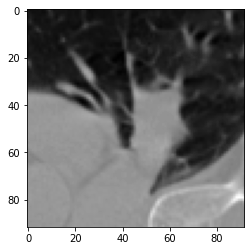

In [0]:
# Plot a random slice
scaled_scan, scaled_mask = rescale(scan, mask)
plt.imshow(scaled_scan[:,:,52], cmap='gray')
plt.show()

In [0]:
# Plot a 3D scan as a video
skvideo.io.vwrite('CT_SCAN.mp4', scaled_scan)
HTML(display_video('CT_SCAN.mp4'))

In [0]:
# Flip Tries
scanflip = np.rot90(scan, k=1, axes=(0, 1))
maskflip = np.rot90(mask, k=1, axes=(0, 1))
scaled_scan, scaled_mask = rescale(scanflip, maskflip)
skvideo.io.vwrite('CT_SCAN.mp4', scaled_scan)
HTML(display_video('CT_SCAN.mp4'))

In [0]:
# Flip Tries
scanflip = np.rot90(scan, k=3, axes=(0, 1))
maskflip = np.rot90(mask, k=3, axes=(0, 1))
scaled_scan, scaled_mask = rescale(scanflip, maskflip)
skvideo.io.vwrite('CT_SCAN.mp4', scaled_scan)
HTML(display_video('CT_SCAN.mp4'))

In [0]:
# Flip Tries
scanflip = np.rot90(scan, k=1, axes=(0, 2))
maskflip = np.rot90(mask, k=1, axes=(0, 2))
scaled_scan, scaled_mask = rescale(scanflip, maskflip)
skvideo.io.vwrite('CT_SCAN.mp4', scaled_scan)
HTML(display_video('CT_SCAN.mp4'))

In [0]:
# Flip Tries
scanflip = np.rot90(scan, k=1, axes=(1, 2))
maskflip = np.rot90(mask, k=1, axes=(1, 2))
scaled_scan, scaled_mask = rescale(scanflip, maskflip)
skvideo.io.vwrite('CT_SCAN.mp4', scaled_scan)
HTML(display_video('CT_SCAN.mp4'))

In [0]:
# Plot a 3D mask as a video
skvideo.io.vwrite('MASK.mp4', scaled_mask)
HTML(display_video('MASK.mp4'))

# 2D Discriminative Slice Extraction

In [0]:
def extract_slice(scan, mask, dim=None):
    """Extract the 2D slice (92x92) of the scan with maximum number of tumor pixels, 
    along a specified dimension or across all if dim not specified"""

    int_mask = mask.astype(int) # bool to 0 1 mask
    n = mask.shape[0] # 92
    d = len(mask.shape) # 3
    best_count = 0
    best_idx = (None, None)

    if dim is None: # get best slice across all dim
      for i in range(d):
        axis = tuple(j for j in range(d) if j != i) # if dim = 0, axis = (1, 2) 
        counts_axis = np.sum(int_mask, axis = axis) # count nb of tumor pixels
        best_idx_axis = np.argmax(counts_axis) 
        best_count_axis = counts_axis[best_idx_axis]
        if best_count_axis > best_count:
          best_count = best_count_axis
          best_idx = (i, best_idx_axis)
    else: # get best slice on the argument dim
        axis = tuple(j for j in range(d) if j != dim) # if dim = 0, axis = (1, 2) 
        counts_axis = np.sum(int_mask, axis = axis) # count nb of tumor pixels
        best_idx_axis = np.argmax(counts_axis)
        best_count = counts_axis[best_idx_axis]
        best_idx = (dim, best_idx_axis)

    best_dim = best_idx[0]
    # print(best_dim, best_idx, best_count)
    if best_dim == 0:
      best_slice = scan[best_idx[1], :, :]
    elif best_dim == 1:
      best_slice = scan[:,best_idx[1], :]
    elif best_dim == 2:
      best_slice = scan[:, :, best_idx[1]]
    return best_slice

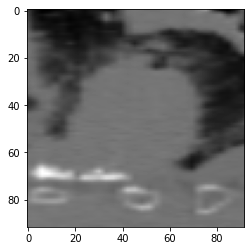

In [0]:
# Plot best slice
best_slice = extract_slice(scan, mask)
plt.imshow(best_slice, cmap='gray')
plt.show()

# Feature Extraction

In [0]:
class Model(nn.Module):
  """Extract 512 features with Resnet18 from a 2D image"""
  def __init__(self):
    super(Model, self).__init__()
    resnet18 = models.resnet18(pretrained = True)
    self.resnet = nn.Sequential(*list(resnet18.children())[:-1]) # remove classifier
  
  def forward(self, x):
    return self.resnet(x)

In [0]:
def extract_features(model, embed_dim, path, dim):
  """Extract features using model that has embeddings of size embed_dim for all
  images in path along dim // also save slice images // returns dic file to tuple of features"""
  filenames = os.listdir(path)
  features = {}
  data_transforms = transforms.Resize(224)

  for file in filenames:
    # Read archive
    archive = np.load(path+'/'+file)
    scan = archive['scan'] 
    mask = archive['mask'] 

    if np.sum(mask.astype(int)) == 0: # no tumor, get random slice
      best_slice = scan[0]
    else:
      # Extract slice, normalize, convert to RGB and to torch tensor
      best_slice = extract_slice(scan, mask, dim)

    # Save slice images
    if dim:
      plt.imsave('best_slices/' + str(dim) + file.split('.')[0] + '.jpg', best_slice, cmap = 'gray')
    else:
      plt.imsave('best_slices/' + file.split('.')[0] + '.jpg', best_slice, cmap = 'gray')

    # Scale to [0, 1], resize to 3 224 224
    maxi = np.max(best_slice) # 1023
    mini = np.min(best_slice) # -1024
    scaled_slice = (1. * best_slice - mini) / (maxi - mini)
    scaled_slice = Image.fromarray((255. * scaled_slice).astype('uint8'), 'L')
    scaled_slice = np.asarray(data_transforms(scaled_slice))
    rgb_slice =  np.repeat(scaled_slice[:, :, np.newaxis], 3, -1)

    # Convert to Torch Tensor
    img = torch.from_numpy(rgb_slice)
    img = img.type('torch.FloatTensor')
    img = img.view(1, 3, 224, 224)
    img = img.to(device)

    # Extract Features
    with torch.no_grad():
        features_img = model(img)
    features[file] = tuple(features_img.flatten().cpu().detach().numpy())
  return features

In [0]:
# Feature extraction and save

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = Model().to(device)

for i in range(3):
  train_features = extract_features(model, 512, train_path+'/images', i)
  with open('train_features_'+str(i)+'.pkl', 'wb') as f:
    pickle.dump(train_features, f)
train_features = extract_features(model, 512, train_path+'/images', None)
with open('train_features.pkl', 'wb') as f:
    pickle.dump(train_features, f)

for i in range(3):
  test_features = extract_features(model, 512, test_path+'/images', i)
  with open('test_features_'+str(i)+'.pkl', 'wb') as f:
    pickle.dump(test_features, f)

test_features = extract_features(model, 512, test_path+'/images', None)
with open('test_features.pkl', 'wb') as f:
    pickle.dump(test_features, f)

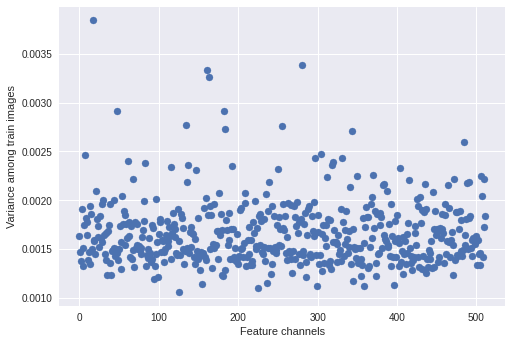

In [0]:
# Look at features variance
train_features = pickle.load(open('train_features.pkl', 'rb'))
df = pd.DataFrame.from_dict(train_features).transpose()
df = df.loc[~(df==0).all(axis=1)]
plt.style.use('seaborn')
plt.scatter(x = np.arange(len(df.var(axis = 0))), y = df.var(axis = 0).values)
plt.xlabel('Feature channels')
plt.ylabel('Variance among train images')
plt.show()

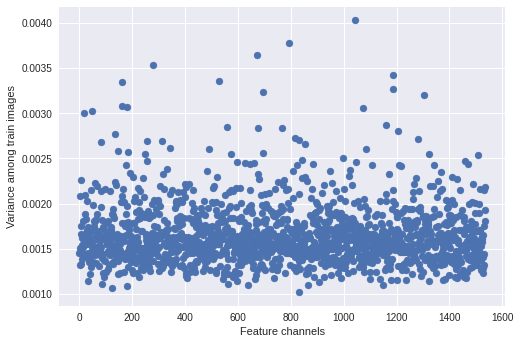

In [0]:
# Look at features variance
train_features = pickle.load(open('train_features_0.pkl', 'rb'))
df0 = pd.DataFrame.from_dict(train_features)
train_features = pickle.load(open('train_features_1.pkl', 'rb'))
df1 = pd.DataFrame.from_dict(train_features)
train_features = pickle.load(open('train_features_2.pkl', 'rb'))
df2 = pd.DataFrame.from_dict(train_features)

df = pd.concat([df0,df1,df2]).transpose()
df = df.loc[~(df==0).all(axis=1)]

plt.style.use('seaborn')
plt.scatter(x = np.arange(len(df.var(axis = 0))), y = df.var(axis = 0).values)
plt.xlabel('Feature channels')
plt.ylabel('Variance among train images')
plt.show()

# Finetuning with negative log likelihood loss - Clean DataLoader


In [0]:
class Net(nn.Module):
  """Resnet + MLP model"""
  def __init__(self, H1 = 128, H2 = 32):
    super(Net, self).__init__()
    resnet = models.resnet18(pretrained = True)
    self.resnet = nn.Sequential(*list(resnet.children())[:-1]) # remove classifier
    """for child in list(self.resnet.children())[:-3]: # freeze first layers
          for param in child.parameters():
              param.requires_grad = False"""
    self.mlp = nn.Sequential(nn.Linear(512, H1), 
                             nn.ReLU(), 
                             nn.Dropout(0.5), 
                             nn.Linear(H1, H2), 
                             nn.ReLU(),
                             nn.Dropout(0.5))
    self.fc = nn.Sequential(nn.Linear(H2, 1, bias = False)) # risk computation

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(-1, 512)
    x = self.mlp(x)
    x = torch.exp(self.fc(x))
    return x

In [0]:
class SlicesDataset(Dataset):
    """
    Tutorial : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """

    def __init__(self, df_y, root_dir, transform=None, input_only = False):
        """
        Args:
            df_y (DataFrame): (PatientID, SurvivalTime, Event)
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df_y = df_y
        self.root_dir = root_dir
        self.transform = transform
        self.image_names = [file_name for root,_,file_names in os.walk(root_dir) for file_name in file_names if file_name.endswith('.jpg')]
        self.input_only = input_only

    def __len__(self):
        return len(self.df_y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read, normalize and resize 
        img_name = os.path.join(self.root_dir,
                                self.image_names[idx])
        best_slice = plt.imread(img_name)
        maxi = np.max(best_slice) 
        mini = np.min(best_slice) 
        scaled_slice = (1. * best_slice - mini) / (maxi - mini)
        scaled_slice = (255. * scaled_slice).astype('uint8')
        scaled_slice = self.transform(scaled_slice)
        scaled_slice = scaled_slice.view((3, 224, 224))

        patient_id = int(os.path.split(img_name)[1].replace(".jpg", "").split("_")[-1])
        
        if self.input_only:
          return scaled_slice.float()

        return scaled_slice.float(), (self.df_y['SurvivalTime'][patient_id], self.df_y['Event'][patient_id])

In [0]:
# Define Dataset and Dataloader

data_transforms = transforms.Compose([transforms.ToPILImage(), transforms.Resize(224), transforms.ToTensor()])

# Get patient ids / weak labels dataframes
df = pd.read_csv("y_train.csv", index_col = 0)
df_train, df_val = train_test_split(df, test_size = 0.25, random_state = 0) # FIX SEED
print("len(df_train)", len(df_train))
print("len(df_val)", len(df_val))
df_test = pd.read_csv("random_submission.csv", index_col = 0)

# Define dataset
dict_df = {"train": df_train, 
           "val": df_val, 
           "test": df_test}
data_dir = "organised_slices"
image_datasets = {x: SlicesDataset(dict_df[x], 
                                   os.path.join(data_dir, x),
                                   data_transforms)
                  for x in ['train', 'val', 'test']}

# Define dataloader
batch_size = 15
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size = batch_size,
                                              shuffle = True, 
                                              num_workers = 0)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

len(df_train) 225
len(df_val) 75


0:	[2s / 2s],		train_loss: 2.2421,	val_loss: 2.2450
1:	[1s / 4s],		train_loss: 2.2339,	val_loss: 2.3224
2:	[1s / 5s],		train_loss: 2.1925,	val_loss: 2.2962
3:	[1s / 7s],		train_loss: 2.1652,	val_loss: 2.2361
4:	[2s / 10s],		train_loss: 2.1574,	val_loss: 2.2320
5:	[2s / 12s],		train_loss: 2.1195,	val_loss: 2.1751
6:	[1s / 14s],		train_loss: 2.1465,	val_loss: 2.2920
7:	[1s / 16s],		train_loss: 2.1428,	val_loss: 2.2402
8:	[2s / 18s],		train_loss: 2.0181,	val_loss: 2.1439
9:	[1s / 20s],		train_loss: 1.9288,	val_loss: 2.2124
10:	[1s / 21s],		train_loss: 1.9269,	val_loss: 2.2068
11:	[1s / 23s],		train_loss: 1.9964,	val_loss: 2.1510
12:	[1s / 25s],		train_loss: 1.9087,	val_loss: 2.1662
13:	[1s / 27s],		train_loss: 1.9107,	val_loss: 2.1655
14:	[2s / 29s],		train_loss: 1.9617,	val_loss: 2.0938
15:	[1s / 31s],		train_loss: 1.8616,	val_loss: 2.1093
16:	[1s / 33s],		train_loss: 1.7972,	val_loss: 2.1852
17:	[2s / 35s],		train_loss: 1.7450,	val_loss: 2.0805
18:	[1s / 37s],		train_loss: 1.6940,	val_l

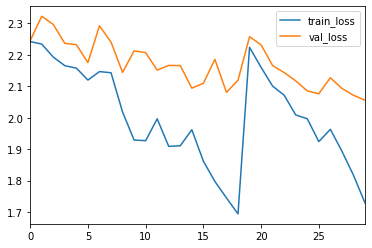

In [0]:
# Define Model
net = Net()
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
optimizer = tt.optim.SGD(lr = 1e-3, momentum = 0.9, weight_decay = 3e-4, 
                         nesterov = True)
model = CoxPH(net, optimizer = optimizer, device = device)

# Training Parameters 
model.optimizer.set_lr(0.001)
epochs = 30
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

# Training
log = model.fit_dataloader(dataloaders['train'], epochs, callbacks, verbose, 
                           val_dataloader = dataloaders['val'])
log.plot()
plt.show()

In [0]:
test_datasets = {x: SlicesDataset(dict_df[x], 
                                   os.path.join(data_dir, x),
                                   data_transforms,
                                  input_only = True)
                  for x in ['train', 'val', 'test']}

# Define dataloader with dataset IMAGE ONLY
batch_size = 15
test_dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size = batch_size,
                                              shuffle = False, 
                                              num_workers = 0) 
                  for x in ['train', 'val', 'test']}

model.compute_baseline_hazards(dataloaders["train"], (df_train['SurvivalTime'].values, df_train['Event'].values)) # Problem, requires dataframe instead of dataloader ...

/usr/local/lib/python3.6/dist-packages/torchtuples/data.py:144: UserWarning: Dataloader might not be deterministic!
  warnings.warn("Dataloader might not be deterministic!")


AttributeError: ignored

In [0]:
surv = model.predict_surv_df(dataloaders["val"])
surv.iloc[:,:10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

ValueError: ignored

Would need to use compute_baseline_hazards with a dataloader instead of dataframes, tiring

# Finetuning with negative log likelihood loss 

In [0]:
def preprocess_images(ids, path):
  """
  Extract from images best slices and outputs numpy arrays of shape 1,3,224,224
  """
  filenames = ['patient_'+'{0:03d}'.format(n)+'.npz' for n in ids]
  slices = np.zeros((len(filenames),3,224,224))
  data_transforms = transforms.Resize(224)

  for i, file in enumerate(filenames):
    # Read archive
    archive = np.load(path+file)
    scan = archive['scan'] 
    mask = archive['mask'] 
    if np.sum(mask.astype(int)) == 0: # no tumor 
      best_slice = scan[0]
    else:
      # Extract slice, normalize, convert to RGB and to torch tensor
      best_slice = extract_slice(scan, mask)
    maxi = np.max(best_slice) # 1023
    mini = np.min(best_slice) # -1024
    scaled_slice = (1.*best_slice-mini) / (maxi-mini)
    scaled_slice = Image.fromarray((255.*scaled_slice).astype('uint8'), 'L')
    scaled_slice = np.asarray(data_transforms(scaled_slice))
    rgb_slice =  np.repeat(scaled_slice[:,:,np.newaxis], 3, -1)
    rgb_slice = rgb_slice.reshape((1,3,224,224))
    slices[i] = rgb_slice
  return slices

def preprocess_images2(ids, path):
  """
  Extract from images best slices and outputs a numpy array of shape 1,1,92,92 (NO REPEAT)
  """
  filenames = ['patient_'+'{0:03d}'.format(n)+'.npz' for n in ids]
  slices = np.zeros((len(filenames),1,92,92))

  for i, file in enumerate(filenames):
    # Read archive
    archive = np.load(path+file)
    scan = archive['scan'] 
    mask = archive['mask'] 
    if np.sum(mask.astype(int)) == 0: # no tumor 
      slices[i] = np.zeros((1,1,92,92))
      continue

    # Extract slice, normalize, convert to RGB and to torch tensor
    best_slice = extract_slice(scan, mask)
    maxi = np.max(best_slice) # 1023
    mini = np.min(best_slice) # -1024
    scaled_slice = (1.*best_slice-mini)/(maxi-mini)
    rgb_slice = scaled_slice.reshape((1,1,92,92))
    slices[i] = rgb_slice
  return slices

In [0]:
# Get dataframes (+ additional features FOR MIXING ONLY)
traindf = pd.read_csv('input_train.csv')
train_labels = pd.read_csv('y_train.csv')
traindf = pd.merge(traindf, train_labels, on = 'PatientID')
testdf = pd.read_csv('input_test.csv', index_col = 0)

In [0]:
# Get data in the right format
# ids = traindf.index.values
ids = traindf['PatientID']
slices = preprocess_images(ids, 'train_data/images/') 
times = traindf['SurvivalTime'].values
events = traindf['Event'].values

In [0]:
# TRY OF MIXING WITH OTHER FEATURES
radiomics_features = ['original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio',
                      'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy', 'original_glcm_Id',
                      'original_glcm_Idm']
clinical_features = ['SourceDataset_l1', 'Nstage']
features_names = radiomics_features + clinical_features
other_features = np.zeros((len(traindf), len(features_names)))
for i, f in enumerate(features_names):
  other_features[:,i] = traindf[f]

In [0]:
# Train Val split
x_train, x_val, times_train, times_val, events_train, events_val = train_test_split(slices, times, events, test_size = 0.2, random_state = 0)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
x_train = torch.from_numpy(x_train).type(torch.FloatTensor).to(device)
x_val = torch.from_numpy(x_val).type(torch.FloatTensor).to(device)

times_train = torch.from_numpy(times_train).to(device)
times_val = torch.from_numpy(times_val).to(device)

events_train = torch.from_numpy(events_train).to(device)
events_val = torch.from_numpy(events_val).to(device)

y_train = (times_train, events_train)
y_val = (times_val, events_val)

# TRY OF MIXING WITH OTHER FEATURES
"""z_train = torch.from_numpy(z_train).type(torch.FloatTensor).to(device)
z_val = torch.from_numpy(z_val).type(torch.FloatTensor).to(device)

x_train = torch.cat([x_train.view(-1,3*92*92),z_train], axis = 1)
x_val = torch.cat([x_val.view(-1,3*92*92),z_val], axis = 1)"""

'z_train = torch.from_numpy(z_train).type(torch.FloatTensor).to(device)\nz_val = torch.from_numpy(z_val).type(torch.FloatTensor).to(device)\n\nx_train = torch.cat([x_train.view(-1,3*92*92),z_train], axis = 1)\nx_val = torch.cat([x_val.view(-1,3*92*92),z_val], axis = 1)'

In [0]:
class Net(nn.Module):
  """Resnet + MLP model"""
  def __init__(self, H1 = 128, H2 = 32): # Z = 8
    super(Net, self).__init__()
    resnet = models.resnet18(pretrained = True)
    self.resnet = nn.Sequential(*list(resnet.children())[:-1]) # remove classifier
    for child in list(self.resnet.children())[:-3]: # freeze first layers
          for param in child.parameters():
              param.requires_grad = False
    self.mlp = nn.Sequential(nn.Linear(512, H1), 
                             nn.ReLU(), 
                             nn.Dropout(0.5), 
                             nn.Linear(H1, H2), 
                             nn.ReLU(),
                             nn.Dropout(0.5))
    self.fc = nn.Sequential(nn.Linear(H2, 1, bias = False)) # risk computation

    # TRY OF MIXING WITH OTHER FEATURES
    """self.mlp2 = nn.Sequential(nn.Linear(Z, 128), 
                             nn.ReLU(), 
                             nn.Dropout(0.2), 
                             nn.Linear(128, 1, bias = False))"""
  
  def forward(self, x):
    # TRY OF MIXING WITH OTHER FEATURES x, y = x[:,:-8], x[:,-8:]
    # x = x.view(-1,3, 92, 92)
    x = self.resnet(x)
    x = x.view(-1,512)
    x = self.mlp(x)
    # TRY OF MIXING WITH OTHER FEATURES x = torch.exp(self.fc(x)+self.mlp2(y)) # hazard
    x = torch.exp(self.fc(x))
    return x

class ConvNet(nn.Module):
  """1-greyscale CNN"""
  def __init__(self, H1 = 128, H2 = 16):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 4, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(4, 8, 5)
    self.dropout = nn.Dropout(0.5)
    self.fc1 = nn.Linear(8 * 5 * 5, H1)
    self.fc2 = nn.Linear(H1, H2)
    self.fc3 = nn.Linear(H2, 1)
  
  def forward(self, x, y):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 8 * 5 * 5)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = torch.exp(self.fc3(x))
    return x

class MiniNet(nn.Module):
  """Debug Model"""
  def __init__(self):
    super(MiniNet, self).__init__()
    self.net = torch.nn.Sequential(nn.Linear(25392, 256),nn.ReLU(),nn.BatchNorm1d(256),
                                   nn.Dropout(0.3),nn.Linear(256, 32),nn.ReLU(),
                                   nn.BatchNorm1d(32),nn.Dropout(0.3),nn.Linear(32, 1))
  
  def forward(self, x):
    x = x.view(-1,25392)
    return self.net(x)

In [0]:
# Define model
net = Net()
# optimizer = tt.optim.Adam 
# (params = net.parameters(),lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# {'params': net.mlp2.parameters(), 'lr': 1e-2} params = [{'params': net.mlp.parameters(), 'lr': 1e-3},{'params': net.resnet.parameters()},{'params': net.fc.parameters(), 'lr': 1e-3},]
optimizer = tt.optim.SGD(lr=1e-3, momentum=0.9, weight_decay=3e-4, nesterov=True)
model = CoxPH(net, optimizer = optimizer, device = device)

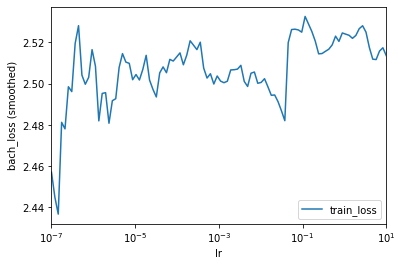

0.0001


In [0]:
# Get best learning rate - OFTEN OVERESTIMATED
batch_size = 20 # TAKE A INT DIVIDING DATA LENGTHS OR DEFINE PROPER TORCH DATALOADERS
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance = 10)
lrfinder.plot()
plt.show()
print(lrfinder.get_best_lr())

0:	[0s / 0s],		train_loss: 2.4998,	val_loss: 2.5497
1:	[1s / 2s],		train_loss: 2.4997,	val_loss: 2.5419
2:	[1s / 3s],		train_loss: 2.5096,	val_loss: 2.5415
3:	[0s / 4s],		train_loss: 2.4848,	val_loss: 2.5374
4:	[1s / 5s],		train_loss: 2.5048,	val_loss: 2.5331
5:	[1s / 6s],		train_loss: 2.4568,	val_loss: 2.5208
6:	[1s / 8s],		train_loss: 2.4613,	val_loss: 2.5103
7:	[0s / 8s],		train_loss: 2.4395,	val_loss: 2.4997
8:	[0s / 9s],		train_loss: 2.4322,	val_loss: 2.4839
9:	[1s / 11s],		train_loss: 2.4090,	val_loss: 2.4576
10:	[0s / 11s],		train_loss: 2.3975,	val_loss: 2.4470
11:	[1s / 13s],		train_loss: 2.3706,	val_loss: 2.4436
12:	[1s / 14s],		train_loss: 2.3525,	val_loss: 2.4375
13:	[1s / 16s],		train_loss: 2.3454,	val_loss: 2.4310
14:	[0s / 16s],		train_loss: 2.2893,	val_loss: 2.4168
15:	[0s / 17s],		train_loss: 2.3160,	val_loss: 2.4317
16:	[0s / 18s],		train_loss: 2.2969,	val_loss: 2.4319
17:	[1s / 19s],		train_loss: 2.2311,	val_loss: 2.4036
18:	[1s / 20s],		train_loss: 2.2309,	val_loss: 

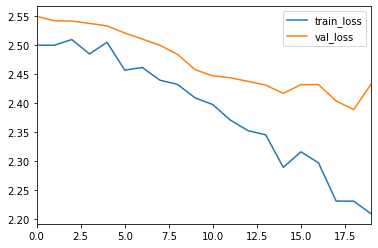

-3.45253324508667


In [0]:
# Training 
model.optimizer.set_lr(0.0005)
batch_size = 20
epochs = 20
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, 
                val_data = (x_val, y_val), val_batch_size = batch_size)
log.plot()
plt.show()
print(model.partial_log_likelihood(*(x_val,y_val)).mean())

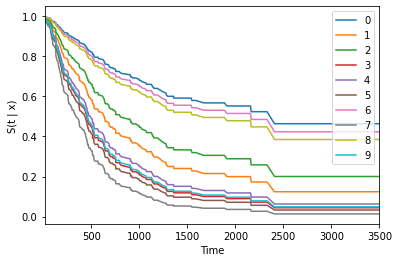

In [0]:
# Validation predictions of survival
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_val)
surv.iloc[:,:10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

0.7154772937905468
0.5206551002947002


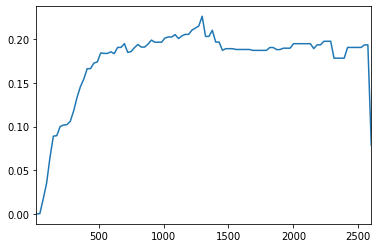

In [0]:
# Evaluation on validation set
dur = times_val.cpu().detach().numpy()
eve = events_val.cpu().detach().numpy()
ev = EvalSurv(surv, dur, eve, censor_surv='km')
print(ev.concordance_td())
time_grid = np.linspace(dur.min(), dur.max(), 100)
_ = ev.brier_score(time_grid).plot()
print(ev.integrated_nbll(time_grid))

In [0]:
# Get test data
test_idx = pd.read_csv('random_submission.csv', index_col = 0)
test_ids = test_idx.index.values
test_slices = preprocess_images(test_ids, 'test_data/images/') 
x_test = torch.from_numpy(test_slices).type(torch.FloatTensor).to(device)

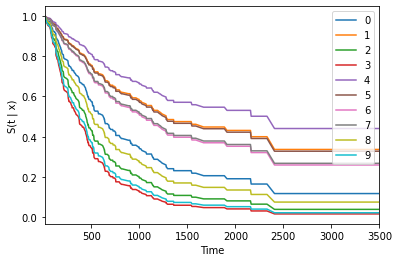

In [0]:
# Test predictions
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_test)
surv.iloc[:, :10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [0]:
surv

0         1         2    ...       122       123       124
duration                                ...                              
14        0.996705  0.998325  0.994999  ...  0.998413  0.995809  0.993623
20        0.996705  0.998325  0.994999  ...  0.998413  0.995809  0.993623
24        0.993409  0.996646  0.990005  ...  0.996822  0.991621  0.987265
25        0.990111  0.994964  0.985017  ...  0.995229  0.987434  0.980923
31        0.986709  0.993226  0.979881  ...  0.993582  0.983120  0.974402
...            ...       ...       ...  ...       ...       ...       ...
3078      0.117163  0.336452  0.038501  ...  0.356333  0.065331  0.015675
3222      0.117163  0.336452  0.038501  ...  0.356333  0.065331  0.015675
3251      0.117163  0.336452  0.038501  ...  0.356333  0.065331  0.015675
3259      0.117163  0.336452  0.038501  ...  0.356333  0.065331  0.015675
3500      0.117163  0.336452  0.038501  ...  0.356333  0.065331  0.015675

[227 rows x 125 columns]

In [0]:
# Write Submission

def predict(prediction, threshold=0.9):
    y_pred = []
    for _, pred in prediction.iteritems():
        times = pred.index.values
        for time in times:
          if pred[time] <= threshold:
            t = time
            break
        else:
          t = times[-1]
        y_pred.append(t)
    return pd.DataFrame(np.array([[y, np.nan] for y in y_pred]), index=test_ids, columns=['SurvivalTime', 'Event'])

predictions = predict(surv, 0.9)
predictions.to_csv("end2endcv.csv")

0.64 on the public test set ... Meh

# Grad-Cam

In [0]:
with torch.no_grad():
  print(model.net(x_train[0].view(1,3,224,224)))

tensor([[1.1627]], device='cuda:0')


In [0]:
img = x_train[0]
plt.imshow(img.cpu().detach().numpy().reshape((224,224,3)).astype(int))
plt.show()

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.resnet[-2][0].register_forward_hook(get_activation('conv1'))

with torch.no_grad():
  output = net(x_train[0].view(1,3,224,224))

act = activation['conv1'].squeeze().cpu().detach().numpy()
fig, axarr = plt.subplots(act.shape[0])
for idx in range(act.shape[0]):
    axarr[idx].imshow(act[idx])
plt.show()

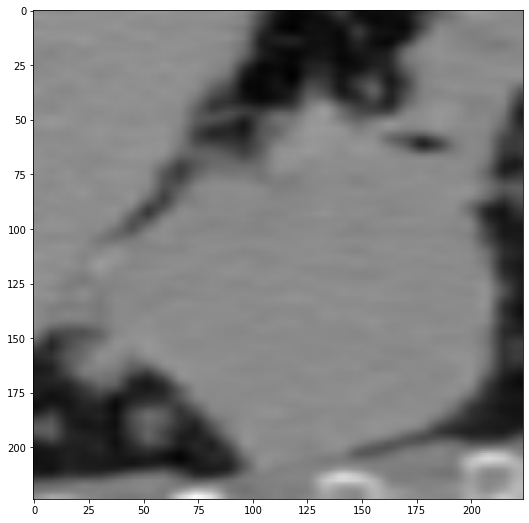

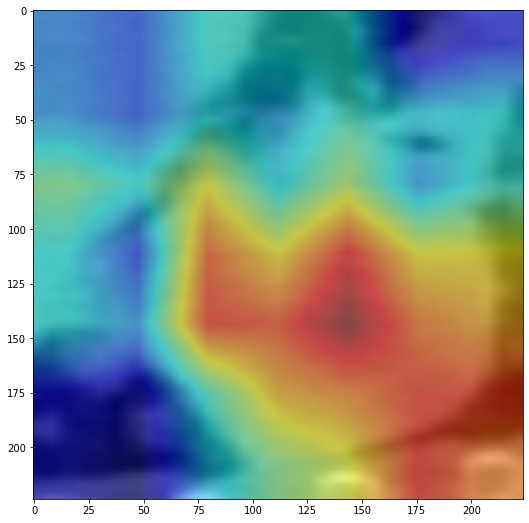

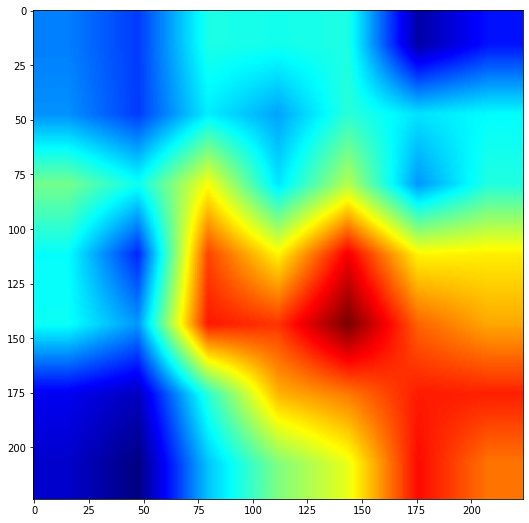

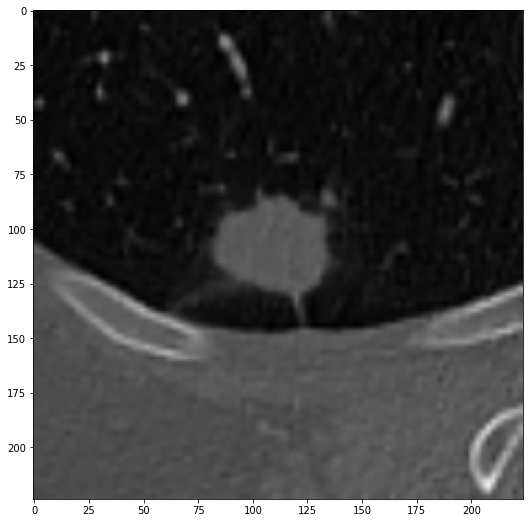

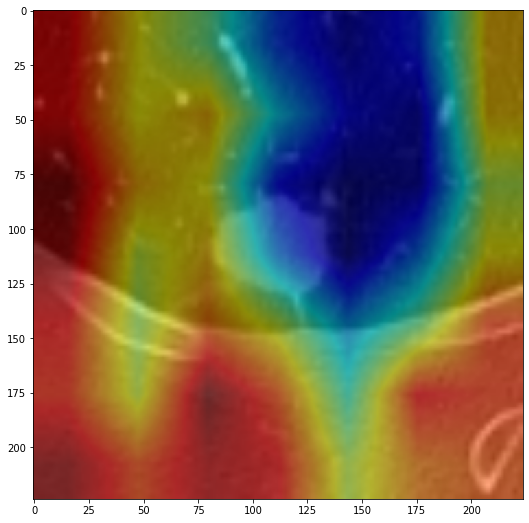

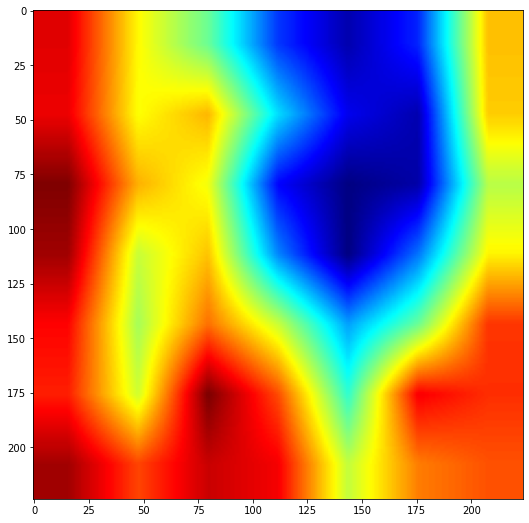

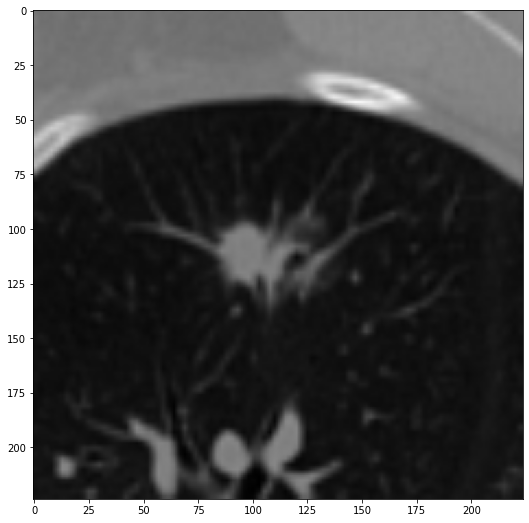

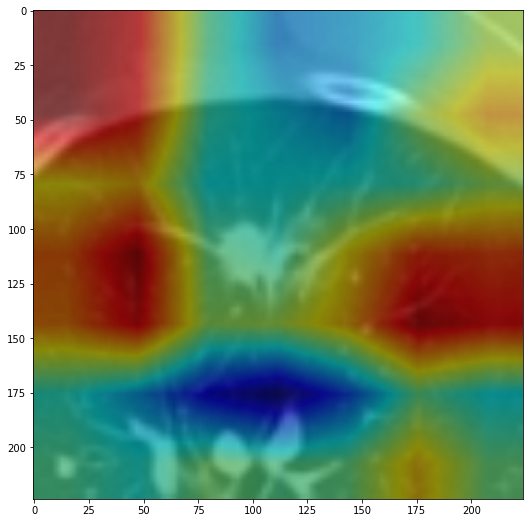

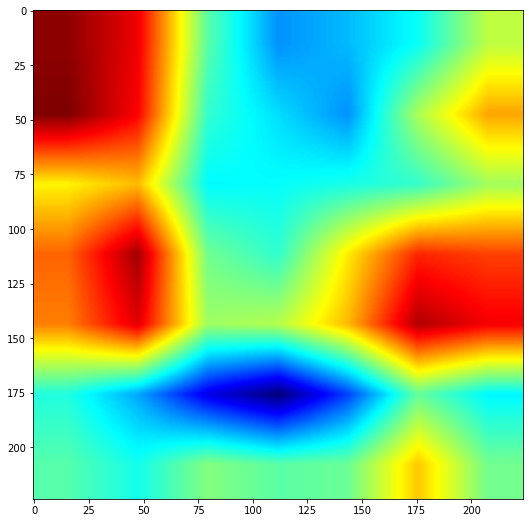

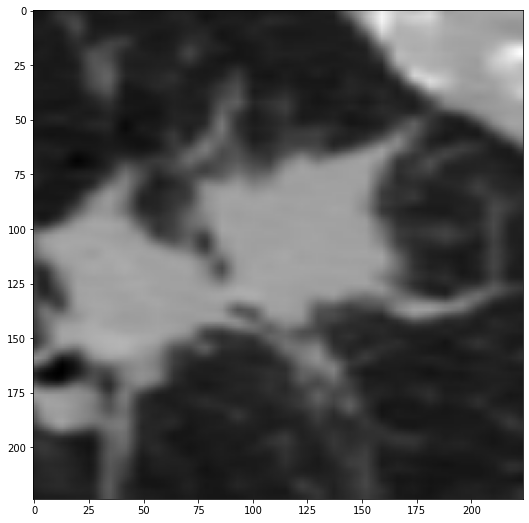

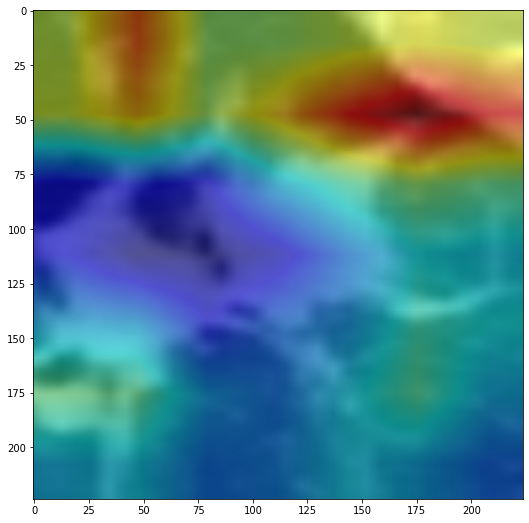

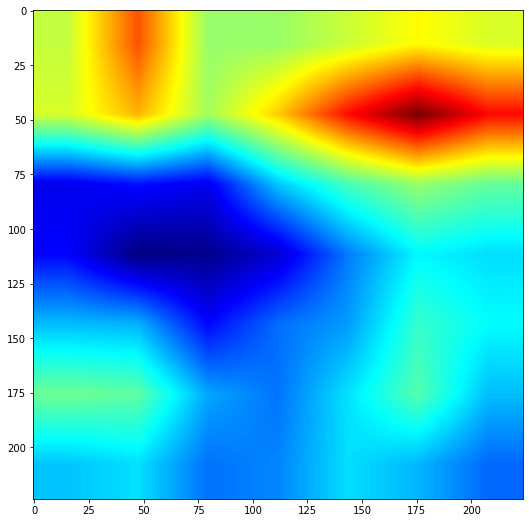

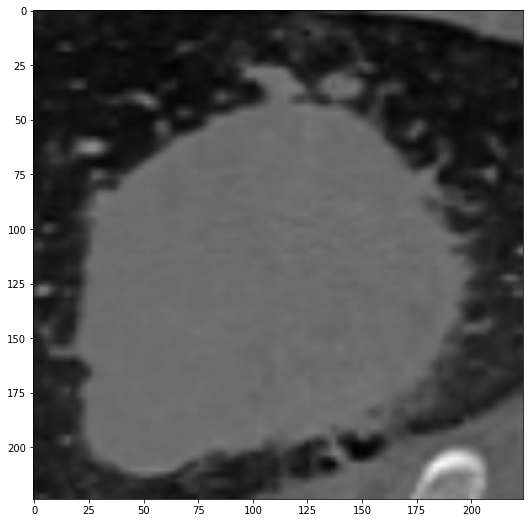

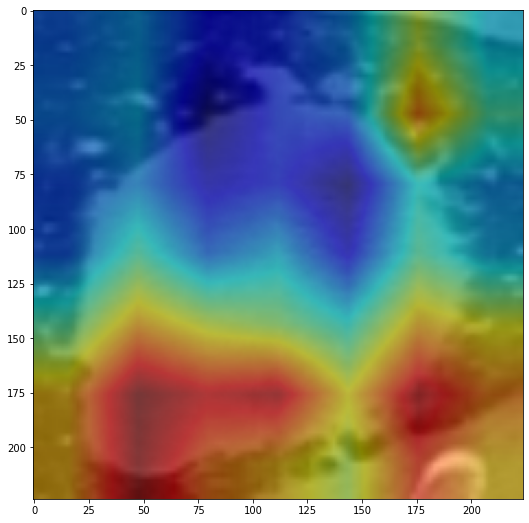

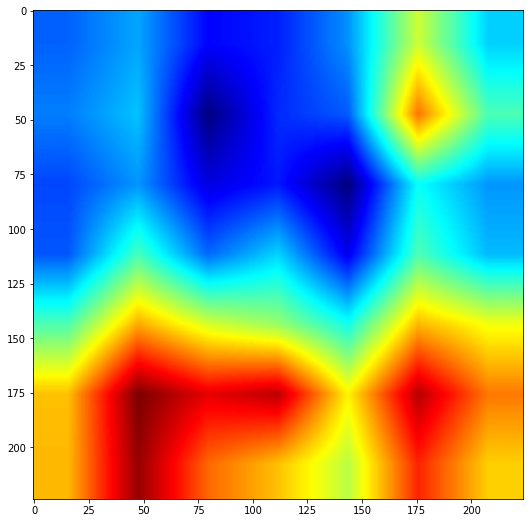

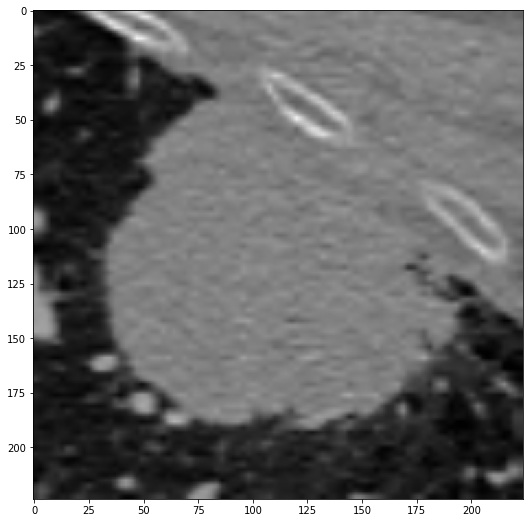

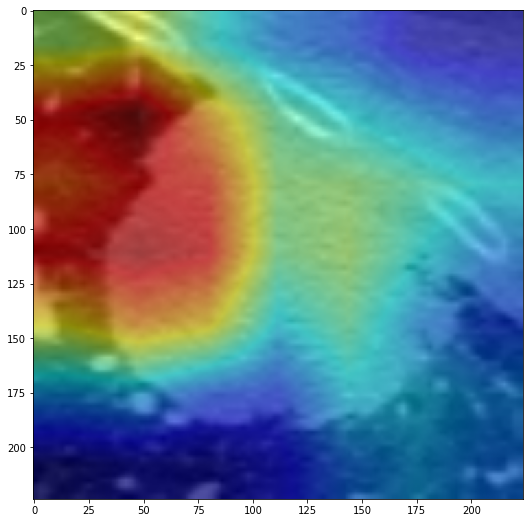

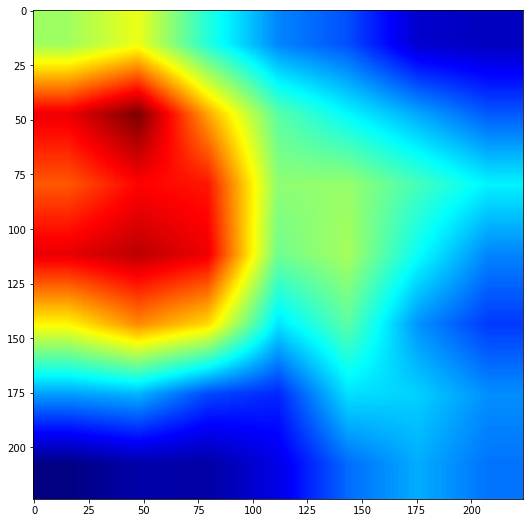

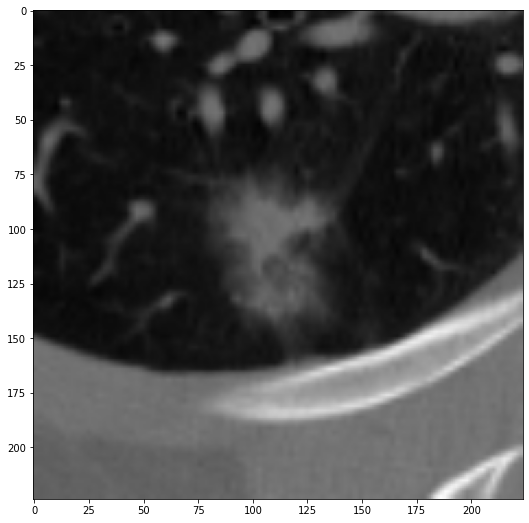

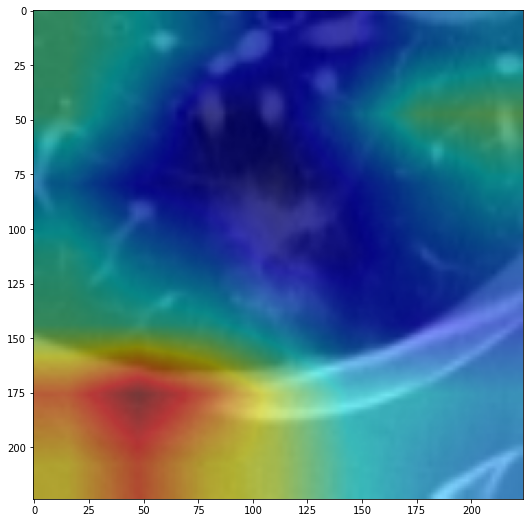

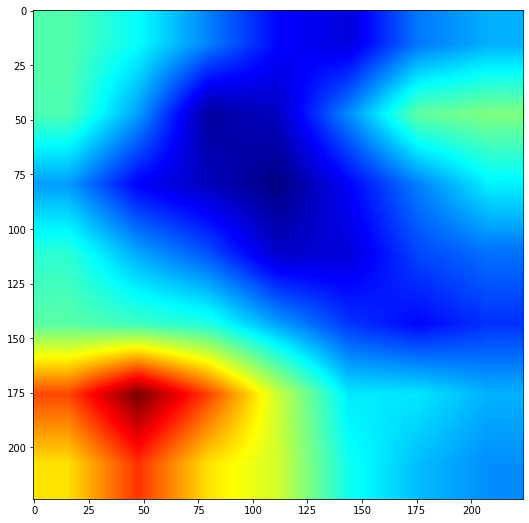

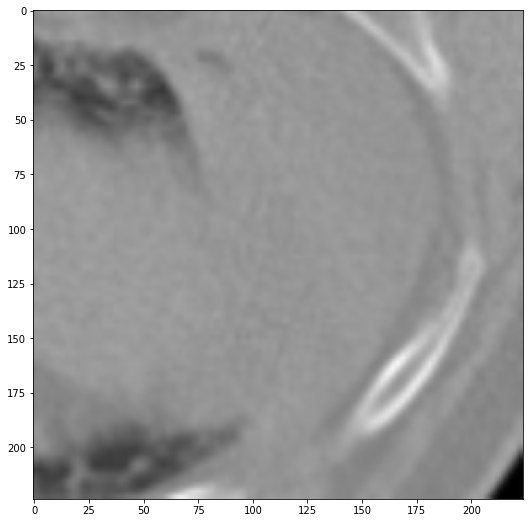

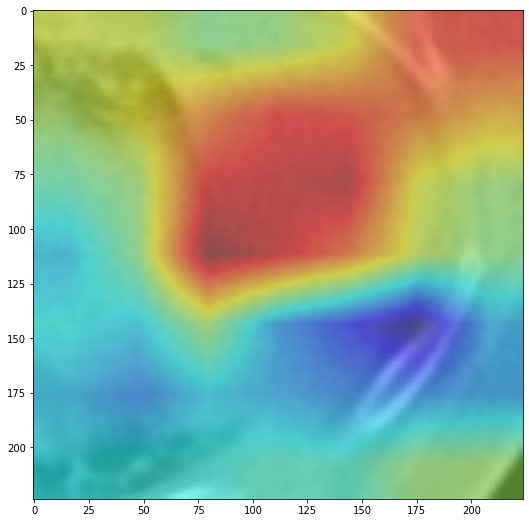

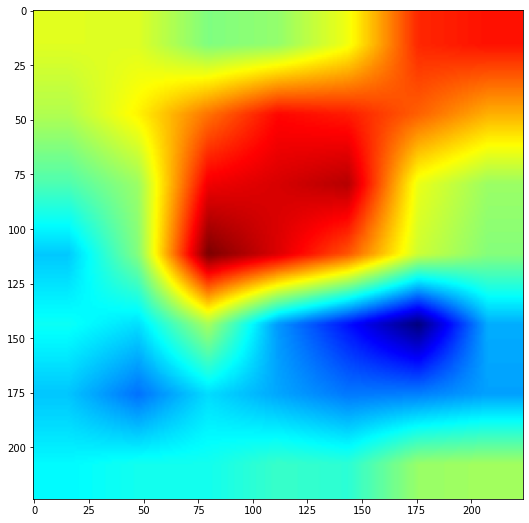

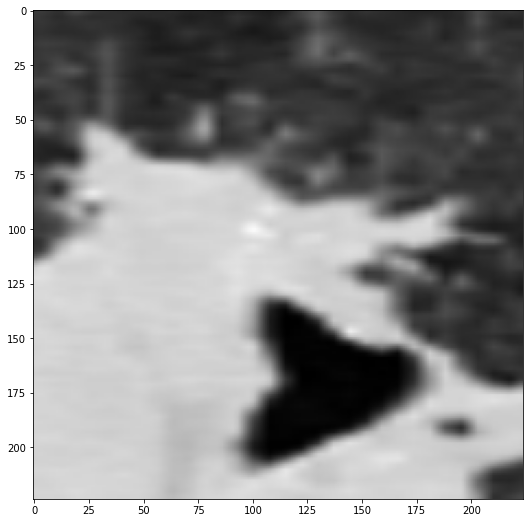

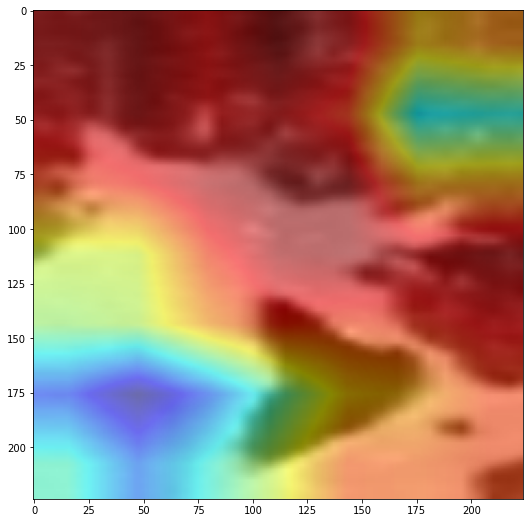

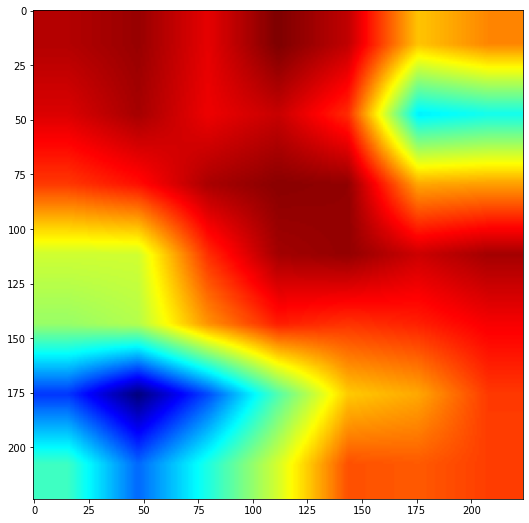

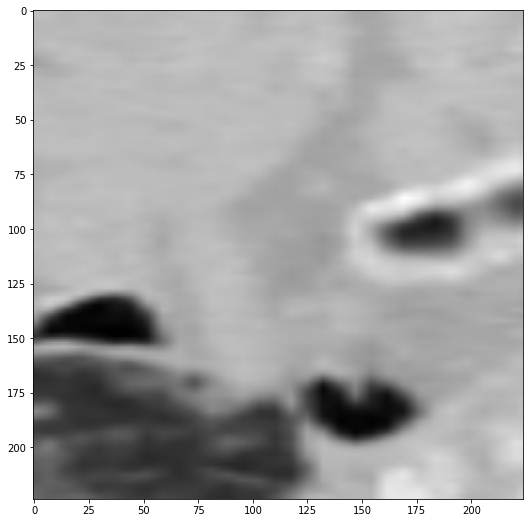

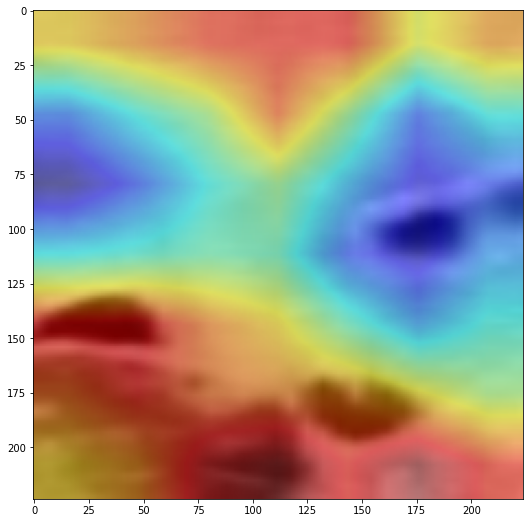

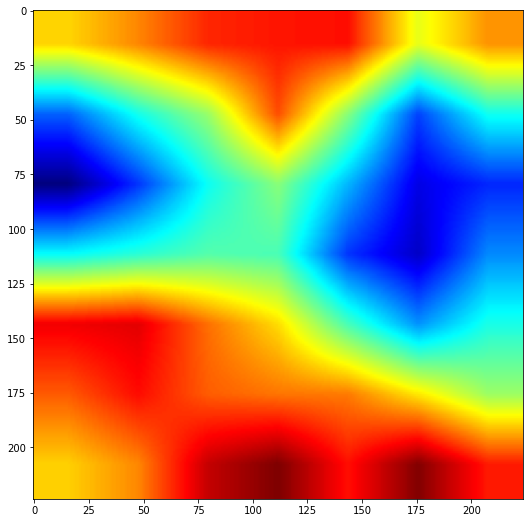

In [0]:
class Extractor():
    """Extract activations, gradients from target layers and get output of the network"""

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        """Assumes that the network has a net.resnet key"""
        activations = []
        self.gradients = []
        for name, module in self.model.resnet._modules.items():
            # Pass through convolutional modules
            x = module(x)
            if name in self.target_layers:
                # Hook gradient at target layers
                x.register_hook(self.save_gradient)
                activations += [x]
        # Get output of the network
        x = x.view(-1,512)
        x = self.model.mlp(x)
        x = self.model.fc(x)
        return activations, x

class Grad_CAM:
    """Compute heatmaps corresponding to the 3 most likely classes"""
    
    def __init__(self, model, target_layers, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.extractor = Extractor(self.model, target_layers)

    def __call__(self, input):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)
            
        cams = []
        # Iterate over top 3 classes
        # Only backwards loss related to the class idx
        self.model.resnet.zero_grad()
        output.backward(retain_graph=True)
            
        # Extract gradients, activations
        grads = self.extractor.gradients[-1].cpu().data.numpy()
        activation = features[-1]
        activation = activation.cpu().data.numpy()[0, :]
            
        # Compute Heatmap and rescale between 0 and 1
        weights = np.mean(grads, axis=(2, 3))[0, :]
        cam = np.zeros(activation.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activation[i, :, :]

        cam = cv2.resize(cam, (224, 224)) # Default interpolation seems to give decent plots
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        cams.append(cam)
        return cams

def show_heatmap(img, cam):
    """Show Heatmap combined with the original image and alone"""
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img / 255) 
    cam = cam / np.max(cam)
    plt.imshow(img)
    plt.show()
    plt.imshow(np.uint8(255 * cam))
    plt.show()
    plt.imshow(np.uint8(255 * heatmap))
    plt.show()

gradcam = Grad_CAM(model=net, target_layers=["7"], use_cuda=False)
for i in range(5):
  img = x_train[i]
  cam = gradcam(img.view(1,3,224,224))
  show_heatmap(img.cpu().detach().numpy().reshape((224,224,3)).astype(int), cam[0])
  img = x_val[i]
  cam = gradcam(img.view(1,3,224,224))
  show_heatmap(img.cpu().detach().numpy().reshape((224,224,3)).astype(int), cam[0])

# DeepSurv (no image)


In [0]:
# Load Features
traindf = pd.read_csv('input_train.csv')
train_labels = pd.read_csv('y_train.csv')
traindf = pd.merge(traindf, train_labels, on = 'PatientID')
testdf = pd.read_csv('input_test.csv', index_col = 0)

In [0]:
# Get data in the right format
ids = traindf['PatientID']
times = traindf['SurvivalTime'].values
events = traindf['Event'].values

In [0]:
# Get features
radiomics_features = ['original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio',
                      'original_shape_Maximum3DDiameter', 'original_glcm_JointEntropy', 'original_glcm_Id',
                      'original_glcm_Idm']
clinical_features = ['SourceDataset_l1', 'Nstage']
features_names = radiomics_features + clinical_features
other_features = np.zeros((len(traindf), len(features_names)))
for i, f in enumerate(features_names):
  other_features[:, i] = traindf[f]

In [0]:
# NO TRAIN VAL SPLIT FOR CROSSVAL? SEE SKORCH
x_train = torch.from_numpy(other_features).type(torch.FloatTensor).to(device)
times_train = torch.from_numpy(times).to(device)
events_train = torch.from_numpy(events).to(device)
y_train = (times_train, events_train)

In [0]:
# Train Val split
x_train, x_val, times_train, times_val, events_train, events_val = 
train_test_split(other_features, times, events, test_size = 0.25)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
x_train = torch.from_numpy(x_train).type(torch.FloatTensor).to(device)
x_val = torch.from_numpy(x_val).type(torch.FloatTensor).to(device)

times_train = torch.from_numpy(times_train).to(device)
times_val = torch.from_numpy(times_val).to(device)

events_train = torch.from_numpy(events_train).to(device)
events_val = torch.from_numpy(events_val).to(device)

y_train = (times_train, events_train)
y_val = (times_val, events_val)

In [0]:
class CoxNet(nn.Module):
  """CoxPH like model"""
  def __init__(self, H1 = 32, H2 = 8):
    super(CoxNet, self).__init__()
    self.net = torch.nn.Sequential(nn.Linear(8, H1),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(H1),
                                   nn.Dropout(0.3),
                                   nn.Linear(H1, H2),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(H2),
                                   nn.Dropout(0.1),
                                   nn.Linear(H2, 1))
  
  def forward(self, x):
    return self.net(x)

In [0]:
net = CoxNet()
# optimizer = tt.optim.Adam 
# (params = net.parameters(),lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# {'params': net.mlp2.parameters(), 'lr': 1e-2} params = [{'params': net.mlp.parameters(), 'lr': 1e-3},{'params': net.resnet.parameters()},{'params': net.fc.parameters(), 'lr': 1e-3},]
optimizer = tt.optim.SGD(lr=1e-3, momentum=0.9, weight_decay=3e-4, nesterov=True)
model = CoxPH(net, optimizer = optimizer, device = device)

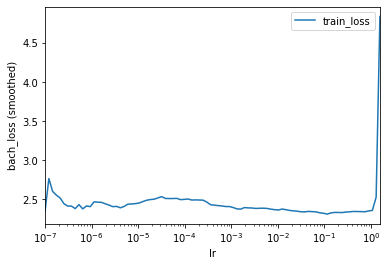

0.01149756995397742


In [0]:
# Get best learning rate - OFTEN OVERESTIMATED
batch_size = 15 # TAKE A INT DIVIDING DATA LENGTHS OR DEFINE PROPER TORCH DATALOADERS
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
lrfinder.plot()
plt.show()
print(lrfinder.get_best_lr())

0:	[0s / 0s],		train_loss: 2.4429,	val_loss: 2.2095
1:	[0s / 0s],		train_loss: 2.3900,	val_loss: 2.1544
2:	[0s / 0s],		train_loss: 2.3255,	val_loss: 2.1429
3:	[0s / 0s],		train_loss: 2.3226,	val_loss: 2.1609
4:	[0s / 0s],		train_loss: 2.3322,	val_loss: 2.1403
5:	[0s / 0s],		train_loss: 2.2812,	val_loss: 2.1468
6:	[0s / 0s],		train_loss: 2.2513,	val_loss: 2.1357
7:	[0s / 0s],		train_loss: 2.0632,	val_loss: 2.1535
8:	[0s / 0s],		train_loss: 2.2358,	val_loss: 2.1369
9:	[0s / 0s],		train_loss: 2.1639,	val_loss: 2.1248
10:	[0s / 0s],		train_loss: 2.1825,	val_loss: 2.1341
11:	[0s / 0s],		train_loss: 2.1505,	val_loss: 2.1339
12:	[0s / 0s],		train_loss: 2.1825,	val_loss: 2.1440
13:	[0s / 0s],		train_loss: 2.1151,	val_loss: 2.1618
14:	[0s / 0s],		train_loss: 2.2074,	val_loss: 2.0753
15:	[0s / 0s],		train_loss: 2.1749,	val_loss: 2.1477
16:	[0s / 0s],		train_loss: 2.2066,	val_loss: 2.1765
17:	[0s / 0s],		train_loss: 2.2191,	val_loss: 2.1509
18:	[0s / 1s],		train_loss: 2.1475,	val_loss: 2.1530
19:

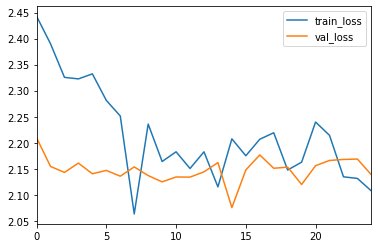

-3.5926055908203125


In [0]:
# Training 
model.optimizer.set_lr(0.0001)
batch_size = 15
epochs = 50
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=(x_val,y_val), val_batch_size=batch_size)
log.plot()
plt.show()
print(model.partial_log_likelihood(*(x_val,y_val)).mean())

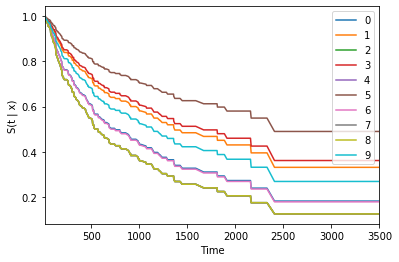

In [0]:
# Validation predictions of survival
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_val)
surv.iloc[:,:10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

0.7023266423357665
0.5279497430178988


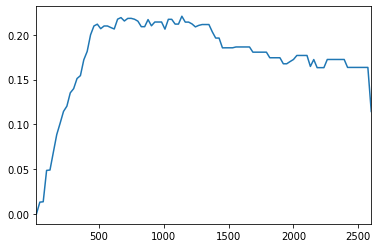

In [0]:
# Evaluation on validation set
dur = times_val.cpu().detach().numpy()
eve = events_val.cpu().detach().numpy()
ev = EvalSurv(surv, dur, eve, censor_surv='km')
print(ev.concordance_td())
time_grid = np.linspace(dur.min(), dur.max(), 100)
_ = ev.brier_score(time_grid).plot()
print(ev.integrated_nbll(time_grid))

# Classification

In [0]:
y_train = pd.read_csv("y_train.csv", index_col = 0)

""" Low survival probability patients """
dead_df = y_train.loc[y_train['Event'] == 1] 
low_survival_index = dead_df.loc[dead_df['SurvivalTime'] <= 300].index
print(f'Number of low survival probability patients: {len(low_survival_index)}')
print(low_survival_index)

""" High survival probability patients """
alive_df = y_train.loc[y_train['Event'] == 0]
high_survival_index = alive_df.loc[alive_df['SurvivalTime'] >= 1000].index
print(f'Number of high survival probability patients: {len(high_survival_index)}')
print(high_survival_index)

Number of low survival probability patients: 66
Int64Index([384, 100, 173,  83, 149, 316, 340, 359, 210, 250, 262, 147, 224,
            272, 418, 116,  30,  29, 266, 175, 303, 367, 208,  17, 237, 355,
            294, 107, 397,  67,  24, 138, 124, 145, 126, 282, 382,  76, 196,
            309, 385,  43, 269,  21,  98, 183, 383,  26, 347,  14, 400, 328,
             15, 358, 159,  93, 255, 395, 346, 112, 345, 299, 373, 213,  56,
            365],
           dtype='int64', name='PatientID')
Number of high survival probability patients: 81
Int64Index([202, 284, 372, 394, 178, 135, 304, 164, 421, 143, 180,  53, 285,
             94, 338, 117, 333, 380,  48, 193,  70, 323, 334, 327, 195,  39,
            257, 331, 403, 388, 151, 308,  22, 130,  91, 275, 115,  42, 406,
              7, 268,  45, 305,  25, 184, 321, 174, 238, 142, 286, 288,  95,
            131, 256,  64, 148,  96,  68, 297, 188, 393, 247,  84,  36, 163,
            211, 391,  11, 401, 141, 279, 154, 362, 157, 381, 165, 409,

In [0]:
# Get labels of our restricted dataset
dead_df = y_train.loc[y_train['Event'] == 1]
dead_df = dead_df.loc[dead_df['SurvivalTime'] <= 300]
alive_df = y_train.loc[y_train['Event'] == 0]
alive_df = alive_df.loc[alive_df['SurvivalTime'] >= 1000]
df = pd.concat([dead_df, alive_df])

In [0]:
class Classifier(nn.Module):
  """Resnet Binary Classifier"""
  def __init__(self):
    super(Classifier, self).__init__()
    resnet = models.resnet18(pretrained = True)
    self.resnet = nn.Sequential(*list(resnet.children())[:-1]) # remove classifier
    for child in list(self.resnet.children())[:-2]: # freeze first layers
          for param in child.parameters():
              param.requires_grad = False
    self.fc = nn.Linear(512, 2) 

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(-1, 512)
    x = self.fc(x)
    return x

In [0]:
class SlicesDataset(Dataset):
    """
    Tutorial : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """

    def __init__(self, df_y, image_names, transform=None):
        """
        Args:
            df_y (DataFrame): (PatientID, SurvivalTime, Event)
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df_y = df_y
        self.transform = transform
        self.image_names = image_names

    def __len__(self):
        return len(self.df_y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read, normalize and resize 
        img_name = self.image_names[idx]
        best_slice = plt.imread(img_name)
        maxi = np.max(best_slice) 
        mini = np.min(best_slice) 
        scaled_slice = (1. * best_slice - mini) / (maxi - mini)
        scaled_slice = (255. * scaled_slice).astype('uint8')
        scaled_slice = self.transform(scaled_slice)
        scaled_slice = scaled_slice.view((3, 224, 224))

        patient_id = int(os.path.split(img_name)[1].replace(".jpg", "").split("_")[-1])

        if self.df_y['Event'][patient_id] == 1 and self.df_y['SurvivalTime'][patient_id] <= 300:
          label = 0
        elif self.df_y['SurvivalTime'][patient_id] >= 1000 and self.df_y['Event'][patient_id] == 0:
          label = 1
        else:
          raise ValueError("Patient not considered")

        return scaled_slice.float(), label

In [0]:
# Define Dataset and Dataloader

data_transforms = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.Resize(224), 
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                      transforms.RandomHorizontalFlip(p = 0.5),
                                      transforms.RandomVerticalFlip(p = 0.5),
                                      transforms.RandomRotation(15),
                                      transforms.ToTensor()])

# Get patient ids / weak labels dataframes
df_train, df_val = train_test_split(df, test_size = 0.2, random_state = 0) # FIX SEED
print("len(df_train)", len(df_train))
print("len(df_val)", len(df_val))

# Define dataset
dict_df = {"train": df_train, 
           "val": df_val}
data_dir = "train_data/images"

def format_ct_scan_name(patient_id):
  head = 'best_slices'
  generic_ct_scan_name = os.path.join(head, 'patient_{}{}.jpg')
  return generic_ct_scan_name.format("0"*(3-len(str(patient_id))), patient_id)

image_datasets = {x: SlicesDataset(dict_df[x], 
                                   [format_ct_scan_name(i) for i in df_train.index.values] if x == 'train'
                                   else [format_ct_scan_name(i) for i in df_val.index.values],
                                   data_transforms)
                  for x in ['train', 'val']}

# Define dataloader
batch_size = 16
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size = batch_size,
                                              shuffle = True, 
                                              num_workers = 4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

len(df_train) 117
len(df_val) 30


In [0]:
# Define Model
model = Classifier()
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
print(torchsummary.summary(model,(3, 224, 224)))
optimizer = optim.SGD(params = model.parameters(), lr = 1e-3, momentum = 0.9, 
                      weight_decay = 3e-4, nesterov = True)
criterion = nn.CrossEntropyLoss()
epochs = 10

for epoch in range(epochs):  
    running_loss = 0.0
    count = 0
    for i, data in enumerate(dataloaders['train']):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() 
        count += len(labels)
        if i % 10 == 0:
          print('[%d, %5d] training loss: %.3f' % (epoch + 1, i + 1, running_loss / count))

    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders["val"]:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Validation accuracy: %d %%' % (100 * correct / total))

print('Finished Training')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

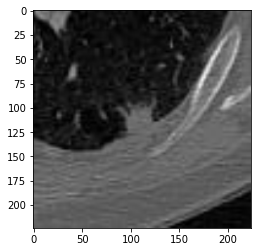

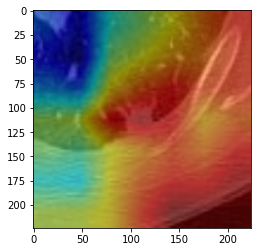

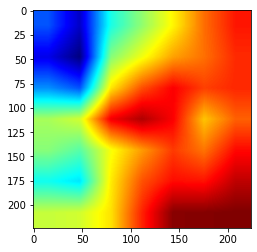

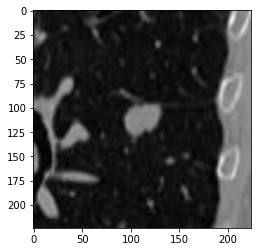

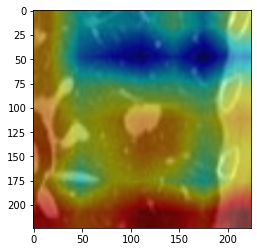

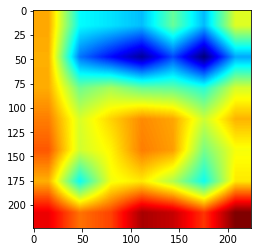

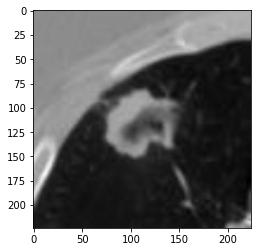

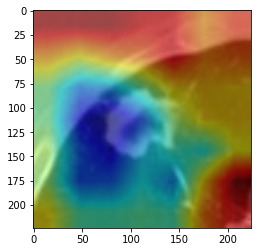

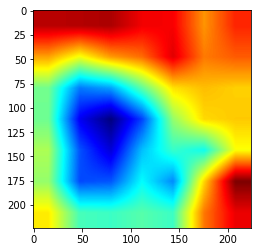

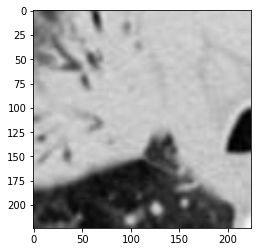

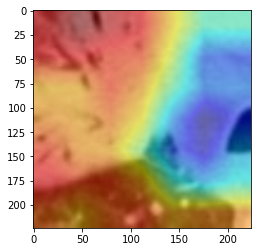

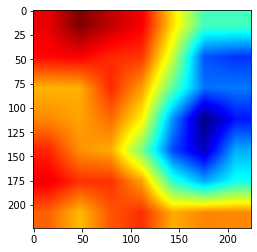

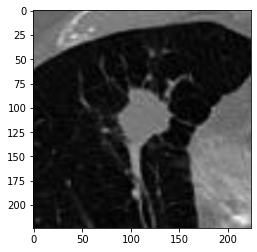

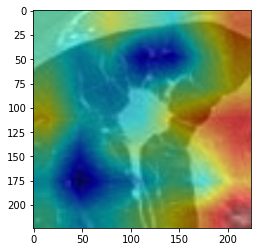

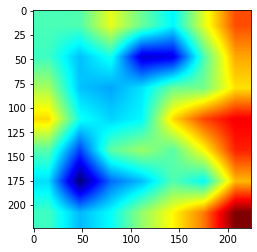

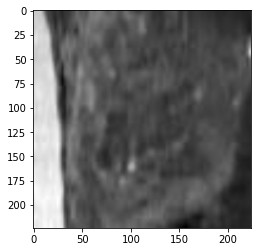

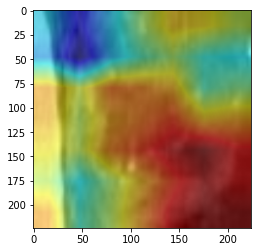

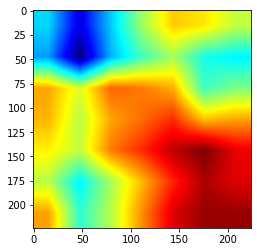

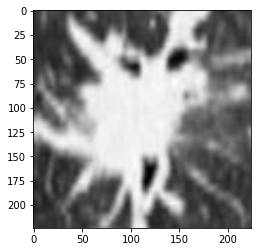

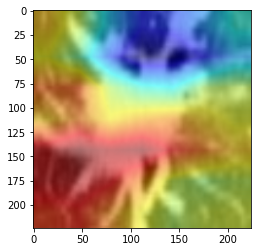

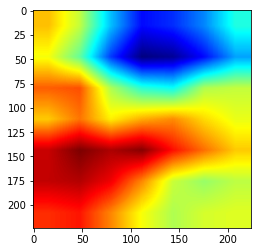

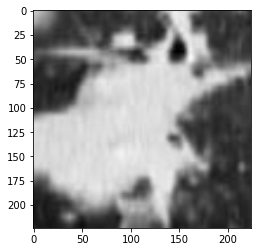

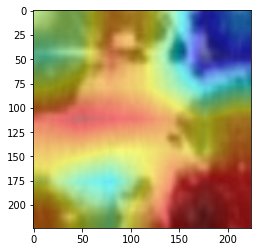

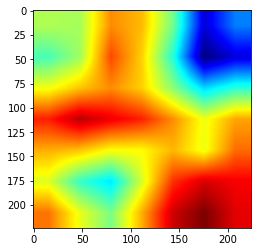

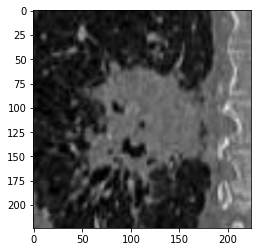

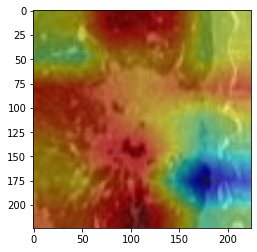

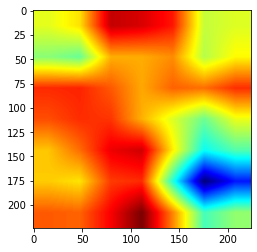

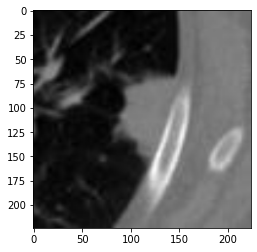

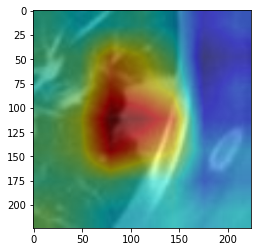

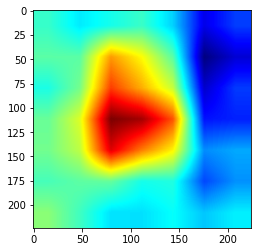

In [0]:
class Extractor():
    """Extract activations, gradients from target layers and get output of the network"""

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        """Assumes that the network has a net.resnet key"""
        activations = []
        self.gradients = []
        for name, module in self.model.resnet._modules.items():
            # Pass through convolutional modules
            x = module(x)
            if name in self.target_layers:
                # Hook gradient at target layers
                x.register_hook(self.save_gradient)
                activations += [x]
        # Get output of the network
        x = x.view(-1,512)
        x = self.model.fc(x)
        return activations, x

class Grad_CAM:
    """Compute heatmaps corresponding to the 3 most likely classes"""
    
    def __init__(self, model, target_layers, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.extractor = Extractor(self.model, target_layers)

    def __call__(self, input):
        features, output = self.extractor(input.to(device))
            
        cams = []
        # Iterate over top 3 classes
        # Only backwards loss related to the class idx
        idx = np.argmax(output.cpu().data.numpy())
        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][idx] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.to(device) * output)
        self.model.resnet.zero_grad()
        self.model.fc.zero_grad()
        one_hot.backward(retain_graph=True)
            
        # Extract gradients, activations
        grads = self.extractor.gradients[-1].cpu().data.numpy()
        activation = features[-1]
        activation = activation.cpu().data.numpy()[0, :]
            
        # Compute Heatmap and rescale between 0 and 1
        weights = np.mean(grads, axis=(2, 3))[0, :]
        cam = np.zeros(activation.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activation[i, :, :]

        cam = cv2.resize(cam, (224, 224)) # Default interpolation seems to give decent plots
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        cams.append(cam)
        return cams

def show_heatmap(img, cam):
    """Show Heatmap combined with the original image and alone"""
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img) 
    cam = cam / np.max(cam)
    plt.imshow(np.uint8(img * 255))
    plt.show()
    plt.imshow(np.uint8(255 * cam))
    plt.show()
    plt.imshow(np.uint8(255 * heatmap))
    plt.show()

train = [format_ct_scan_name(i) for i in df_train.index.values] 
val = [format_ct_scan_name(i) for i in df_val.index.values]

def normalize(best_slice):
  maxi = np.max(best_slice) 
  mini = np.min(best_slice) 
  scaled_slice = (1. * best_slice - mini) / (maxi - mini)
  scaled_slice = (255. * scaled_slice).astype('uint8')
  scaled_slice = data_transforms(scaled_slice)
  scaled_slice = scaled_slice.view((3, 224, 224))
  return scaled_slice

data_transforms = transforms.Compose([transforms.ToPILImage(), 
                                      transforms.Resize(224),
                                      transforms.ToTensor()])

gradcam = Grad_CAM(model=model, target_layers=["7"], use_cuda=False)
for i in range(5):
  img = normalize(plt.imread(train[i])).to(device)
  cam = gradcam(img.view(1,3,224,224))
  show_heatmap(img.cpu().detach().numpy().transpose(2,1,0), cam[0])
  img = normalize(plt.imread(val[i])).to(device)
  cam = gradcam(img.view(1,3,224,224))
  show_heatmap(img.cpu().detach().numpy().transpose(2,1,0), cam[0])

# MSE Training


In [0]:
# Load data

train_path = 'train_data/'
test_path = 'test_data/'
training_ct_scan_names = [os.path.join(root, file_name) for root,_,file_names in os.walk(train_path)\
                          for file_name in file_names if file_name.endswith('.npz')]
test_ct_scan_names = [os.path.join(root, file_name) for root,_,file_names in os.walk(test_path)\
                      for file_name in file_names if file_name.endswith('.npz')]
print("Number of training ct scans : {}".format(len(training_ct_scan_names)))
print("Number of test ct scans : {}".format(len(test_ct_scan_names)))

Number of training ct scans : 300
Number of test ct scans : 125


In [0]:
# Copy data for train / val / test split

df = pd.read_csv("y_train.csv", index_col=0)
df_train, df_val = train_test_split(df, test_size=0.25, random_state=0)
print("len(df_train)", len(df_train))
print("len(df_val)", len(df_val))
df_test = pd.read_csv("random_submission.csv", index_col=0)

def format_ct_scan_name(generic_ct_scan_name, patient_id):
  return generic_ct_scan_name.format("0"*(3-len(str(patient_id))), patient_id)

# head, _ = os.path.split(training_ct_scan_names[0])
head = "best_slices"
# generic_ct_scan_name = os.path.join(head, 'patient_{}{}.npz')
generic_ct_scan_name = os.path.join(head, 'patient_{}{}.jpg')

train_ct_scan_names = [format_ct_scan_name(generic_ct_scan_name, patient_id)\
                       for patient_id in df_train.index.values]
val_ct_scan_names = [format_ct_scan_name(generic_ct_scan_name, patient_id)\
                     for patient_id in df_val.index.values]

organised_data_folder_name = "organised_slices"
# organised_data_folder_name = "organised_data"
!rm -rf $organised_data_folder_name/*
!mkdir -p $organised_data_folder_name
!mkdir -p $organised_data_folder_name/train
!mkdir -p $organised_data_folder_name/val
!mkdir -p $organised_data_folder_name/test

for image_path_and_names, ml_set_name in zip([train_ct_scan_names, val_ct_scan_names, test_ct_scan_names], 
                                              ["train", "val", "test"]):
  for image_path_and_name in image_path_and_names: 
    image_name = os.path.split(image_path_and_name)[1]
    shutil.copyfile(image_path_and_name, os.path.join(organised_data_folder_name, ml_set_name, image_name))

In [0]:
class CTscanDataset(Dataset):
    """
    Tutorial : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """

    def __init__(self, df_y, root_dir, transform=None):
        """
        Args:
            df_y (DataFrame): (PatientID, SurvivalTime, Event)
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df_y = df_y
        self.root_dir = root_dir
        self.transform = transform
        self.image_names = [file_name for root,_,file_names in os.walk(root_dir) for file_name in file_names if file_name.endswith('.npz')]


    def __len__(self):
        return len(self.df_y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.image_names[idx])
        archive = np.load(img_name)
        scan = archive['scan']
        #mask = archive['mask']
        patiend_id = int(os.path.split(img_name)[1].replace(".npz", "").split("_")[-1])

        sample = {'scan': scan.astype(float), 'y': np.hstack((patiend_id, self.df_y.loc[patiend_id]))}

        if self.transform:
            sample['scan'] = self.transform(sample["scan"])

        return (sample["scan"]/(2**16-1)).float(), sample["y"]
        # .float() : converts torch.float (cpu) to torch.cuda.FloatTensor (GPU, cuda)
        # see https://pytorch.org/docs/stable/tensors.html

In [0]:
# Define Dataloader

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

dict_df_y = {"train": df_train, 
             "val": df_val, 
             "test": df_test}
data_dir = "organised_data"
image_datasets = {x: CTscanDataset(dict_df_y[x], 
                                   os.path.join(data_dir, x),
                                   data_transforms[x])
                  for x in ['train', 'val', 'test']}

batch_size = 16
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=batch_size,
                                              shuffle=True, 
                                              num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
model = models.resnet18(pretrained=True)
model.children

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


<bound method Module.children of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [0]:
class Model(nn.Module):
    def __init__(self, out_features=1):
        super(Model, self).__init__()
        model = torchvision.models.resnet18(pretrained=True)
        model = nn.Sequential(*list(model.children())[:-1])
        for child in list(model.children())[:-3]: # freeze first layers
          for param in child.parameters():
              param.requires_grad = False
        self.input_conv = nn.Conv2d(in_channels=92, out_channels=3, kernel_size=3)      
        self.model = model
        self.fc = nn.Linear(in_features=512, out_features=out_features, bias=True)
        
    def forward(self, x):
        x = self.input_conv(x)
        x = self.model(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x    

In [0]:
model = Model()

for name, param in model.named_parameters():
    print(name, param.requires_grad)

input_conv.weight True
input_conv.bias True
model.0.weight False
model.1.weight False
model.1.bias False
model.4.0.conv1.weight False
model.4.0.bn1.weight False
model.4.0.bn1.bias False
model.4.0.conv2.weight False
model.4.0.bn2.weight False
model.4.0.bn2.bias False
model.4.1.conv1.weight False
model.4.1.bn1.weight False
model.4.1.bn1.bias False
model.4.1.conv2.weight False
model.4.1.bn2.weight False
model.4.1.bn2.bias False
model.5.0.conv1.weight False
model.5.0.bn1.weight False
model.5.0.bn1.bias False
model.5.0.conv2.weight False
model.5.0.bn2.weight False
model.5.0.bn2.bias False
model.5.0.downsample.0.weight False
model.5.0.downsample.1.weight False
model.5.0.downsample.1.bias False
model.5.1.conv1.weight False
model.5.1.bn1.weight False
model.5.1.bn1.bias False
model.5.1.conv2.weight False
model.5.1.bn2.weight False
model.5.1.bn2.bias False
model.6.0.conv1.weight True
model.6.0.bn1.weight True
model.6.0.bn1.bias True
model.6.0.conv2.weight True
model.6.0.bn2.weight True
model.6.0

In [0]:
model_directory_name = "models"
!rm -rf $model_directory_name/*
!mkdir -p $model_directory_name

In [0]:
# Tutorial : https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation metric or loss doesn't improve after a given patience."""
    def __init__(self, model_directory_name, metric_or_loss_name, greater_is_better=True, patience=7, verbose=False, delta=0):
        """
        Args:
            model_directory_name (string): Where to save weights
            metric_or_loss_name (string): Name of loss or metric that is being monitored
            greater_is_better (bool): For example, if the metric is accuracy, the greater_is_better=True
                                      but if the metric is mean squared error (MSE), then
                                      greater_is_better=False
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """

        if greater_is_better:
          self.factor = 1
        else:
          self.factor = -1

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.model_directory_name = model_directory_name
        self.metric_or_loss_name = metric_or_loss_name
        self.val_metric_or_loss_min = (-self.factor)*np.Inf
        

    def __call__(self, val_metric_or_loss, model):

        score = self.factor*val_metric_or_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model)
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(score, model)
            self.counter = 0

    def save_checkpoint(self, val_metric_or_loss, model):
        '''Saves model when validation metric or loss has improved.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_metric_or_loss_min:.6f} --> {val_metric_or_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), os.path.join(self.model_directory_name, 
                                                    'checkpoint_val_{}_{}.pt'.format(self.metric_or_loss_name, 
                                                                                     np.round(val_metric_or_loss, 6))))
        self.val_metric_or_loss_min = val_metric_or_loss

In [0]:
# Tutorial : https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model,
                criterion,
                optimizer,
                scheduler,
                patience,
                df_y_train,
                df_y_train_pred,
                df_y_val,
                df_y_val_pred,
                model_directory_name,
                metric_or_loss_name,
                greater_is_better,
                num_epochs=25):
    since = time.time()

    # initialize the early_stopping object
    early_stopping = EarlyStopping(model_directory_name,
                                   metric_or_loss_name,
                                   greater_is_better=greater_is_better,
                                   patience=patience)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_metric = 0.0   

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                numpy_labels = labels.numpy()
                patient_ids = numpy_labels[:, 0]
                inputs = inputs.to(device)
                labels = labels[:, 1].float() # SurvivalTime              
                labels = torch.unsqueeze(labels, 1)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    if phase == 'train':
                      df_labels = df_y_train
                      df_y_train_pred.loc[patient_ids, "SurvivalTime"] = outputs.cpu().detach().numpy().ravel()
                      df_preds = df_y_train_pred
                    else:
                      df_labels = df_y_val
                      df_y_val_pred.loc[patient_ids, "SurvivalTime"] = outputs.cpu().detach().numpy().ravel()
                      df_preds = df_y_val_pred

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            if all(survival_time > 1. for survival_time in df_preds["SurvivalTime"].values):
              # According the function given in the competition to compute the C-index :
              # - Predicted times should all be positive
              # - Predicted y_true_times all strictly greater than 1 because it is written :
              #   Predicted y_true_times all below 1. It should be in days.
              #   Make sure that you are not predicting risk instead of time.
              epoch_metric = cindex(df_labels, df_preds)
            else:
              epoch_metric = -np.inf # not able to compute C-index

            print('{} Loss: {:.4f} Metric: {:.4f}'.format(
                phase, epoch_loss, epoch_metric))

            # deep copy the model
            if phase == 'val' and epoch_metric > best_metric:
                best_metric = epoch_metric
                best_model_wts = copy.deepcopy(model.state_dict())

        
        if phase == 'val':
          early_stopping(epoch_metric, model)
          
          if early_stopping.early_stop:
              print("Early stopping")
              break

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Metric: {:4f}'.format(best_metric))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
model = Model()
model = model.to(device)

criterion = nn.MSELoss()

# all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay lr by a factor of gamma every step_size epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 20
patience = 10
metric_or_loss_name = "cindex"
greater_is_better = True

df_train_pred = df_train.copy()
df_train_pred[["SurvivalTime", "Event"]] = np.nan # `Event`column, whose value does not matter
df_val_pred = df_val.copy()
df_val_pred[["SurvivalTime", "Event"]] = np.nan # `Event`column, whose value does not matter

trained_model = train_model(model, 
                            criterion,
                            optimizer,
                            scheduler,
                            patience,
                            df_train,
                            df_train_pred,
                            df_val,
                            df_val_pred,
                            model_directory_name,
                            metric_or_loss_name,
                            greater_is_better,
                            num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 1208063.5683 Metric: -inf
val Loss: 1458200.8900 Metric: -inf

Epoch 1/19
----------
train Loss: 1185878.7805 Metric: -inf
val Loss: 1440947.2267 Metric: -inf
EarlyStopping counter: 1 out of 10

Epoch 2/19
----------
train Loss: 1163673.6636 Metric: -inf
val Loss: 1437320.7750 Metric: 0.4108

Epoch 3/19
----------
train Loss: 1138978.3278 Metric: 0.7444
val Loss: 1438225.8933 Metric: 0.4545

Epoch 4/19
----------
train Loss: 1103585.7347 Metric: -inf
val Loss: 1334161.8100 Metric: -inf
EarlyStopping counter: 1 out of 10

Epoch 5/19
----------
train Loss: 1064950.2433 Metric: -inf
val Loss: 1206076.0383 Metric: -inf
EarlyStopping counter: 2 out of 10

Epoch 6/19
----------
train Loss: 1016374.1410 Metric: -inf
val Loss: 1062894.5750 Metric: 0.6863

Epoch 7/19
----------
train Loss: 988697.9856 Metric: -inf
val Loss: 1247908.5775 Metric: -inf
EarlyStopping counter: 1 out of 10

Epoch 8/19
----------
train Loss: 984886.7847 Metric: -inf
val Loss: 1260781.

In [0]:
def predict(model, df_y_test_pred):
    model.eval()

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            numpy_labels = labels.numpy()
            patient_ids = numpy_labels[:, 0]
            inputs = inputs.to(device)
            outputs = model(inputs)
            df_y_test_pred.loc[patient_ids, "SurvivalTime"] = outputs.cpu().detach().numpy().ravel()

    return df_y_test_pred

df_y_test_pred = predict(model, df_y_test_pred)

# Segmentation

In [0]:
# 3D-U-Net Implementation taken from https://github.com/pykao/BraTS2018-tumor-segmentation/blob/master/models/unet.py

def normalization(planes, norm='gn'):
    if norm == 'bn':
        m = nn.BatchNorm3d(planes)
    elif norm == 'gn':
        m = nn.GroupNorm(4, planes)
    elif norm == 'in':
        m = nn.InstanceNorm3d(planes)
    else:
        raise ValueError('normalization type {} is not supported'.format(norm))
    return m


class ConvD(nn.Module):
    def __init__(self, inplanes, planes, dropout=0.0, norm='gn', first=False):
        super(ConvD, self).__init__()

        self.first = first
        self.maxpool = nn.MaxPool3d(2, 2)

        self.dropout = dropout
        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Conv3d(inplanes, planes, 3, 1, 1, bias=False)
        self.bn1   = normalization(planes, norm)

        self.conv2 = nn.Conv3d(planes, planes, 3, 1, 1, bias=False)
        self.bn2   = normalization(planes, norm)

        self.conv3 = nn.Conv3d(planes, planes, 3, 1, 1, bias=False)
        self.bn3   = normalization(planes, norm)

    def forward(self, x):
        if not self.first:
            x = self.maxpool(x)
        x = self.bn1(self.conv1(x))
        y = self.relu(self.bn2(self.conv2(x))) # NOT USED?
        if self.dropout > 0:
            y = F.dropout3d(y, self.dropout)
        # y = self.bn3(self.conv3(x))
        y = self.bn3(self.conv3(y))
        return self.relu(x + y)


class ConvU(nn.Module):
    def __init__(self, planes, norm='gn', first=False):
        super(ConvU, self).__init__()

        self.first = first

        if not self.first:
            self.conv1 = nn.Conv3d(2*planes, planes, 3, 1, 1, bias=False)
            self.bn1   = normalization(planes, norm)

        self.conv2 = nn.Conv3d(planes, planes//2, 1, 1, 0, bias=False)
        self.bn2   = normalization(planes//2, norm)

        self.conv3 = nn.Conv3d(planes, planes, 3, 1, 1, bias=False)
        self.bn3   = normalization(planes, norm)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, prev):
        # final output is the localization layer
        if not self.first:
            x = self.relu(self.bn1(self.conv1(x)))

        y = F.upsample(x, scale_factor=2, mode='trilinear', align_corners=False)
        y = self.relu(self.bn2(self.conv2(y)))

        y = torch.cat([prev, y], 1)
        y = self.relu(self.bn3(self.conv3(y)))

        return y


class Unet(nn.Module):
    def __init__(self, c=4, n=16, dropout=0.5, norm='gn', num_classes=5):
        super(Unet, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2,
                mode='trilinear', align_corners=False)

        self.convd1 = ConvD(c,     n, dropout, norm, first=True)
        self.convd2 = ConvD(n,   2*n, dropout, norm)
        self.convd3 = ConvD(2*n, 4*n, dropout, norm)
        self.convd4 = ConvD(4*n, 8*n, dropout, norm)
        self.convd5 = ConvD(8*n,16*n, dropout, norm)

        self.convu4 = ConvU(16*n, norm, True)
        self.convu3 = ConvU(8*n, norm)
        self.convu2 = ConvU(4*n, norm)
        self.convu1 = ConvU(2*n, norm)

        self.seg3 = nn.Conv3d(8*n, num_classes, 1)
        self.seg2 = nn.Conv3d(4*n, num_classes, 1)
        self.seg1 = nn.Conv3d(2*n, num_classes, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d) or isinstance(m, nn.GroupNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1 = self.convd1(x)
        x2 = self.convd2(x1)
        x3 = self.convd3(x2)
        x4 = self.convd4(x3)
        x5 = self.convd5(x4)

        y4 = self.convu4(x5, x4)
        y3 = self.convu3(y4, x3)
        y2 = self.convu2(y3, x2)
        y1 = self.convu1(y2, x1)

        y3 = self.seg3(y3)
        y2 = self.seg2(y2) + self.upsample(y3)
        y1 = self.seg1(y1) + self.upsample(y2)

        return y1

In [0]:
class SegmentationDataset(Dataset):
    """
    Tutorial : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    """

    def __init__(self, root_dir, transform=None, test = False):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_names = [file_name for root, _, file_names in os.walk(root_dir)
        for file_name in file_names if file_name.endswith('.npz')] 
        self.test = test

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read, normalize and resize 
        img_name = os.path.join(self.root_dir,
                                self.image_names[idx])
        archive = np.load(img_name)
        scan = archive['scan'] 
        mask = archive['mask'] 
        
        # 4 flips possible (0, 90, 180, 270) along each of the 3 dimensions
        """for ax in [(0,1), (0,2), (1,2)]:
          rd = np.random.rand()
          if 0.25 <= rd < 0.5:
              scan = np.rot90(scan, k=1, axes=ax)
              mask = np.rot90(mask, k=1, axes=ax)
          elif 0.5 <= rd < 0.75:
              scan = np.rot90(scan, k=2, axes=ax)
              mask = np.rot90(mask, k=2, axes=ax)
          elif 0.75 <= rd:
              scan = np.rot90(scan, k=3, axes=ax)
              mask = np.rot90(mask, k=3, axes=ax)"""

        maxi = np.max(scan) 
        mini = np.min(scan) 
        scaled_scan = (1. * scan - mini) / (maxi - mini)
        scaled_scan = self.transform((255. * scaled_scan)).view(-1,1,92,92,92)
        scaled_scan = F.interpolate(scaled_scan, size=128, mode = 'nearest')

        tmask = self.transform(255. * mask.astype('uint8')).view(-1,1,92,92,92)
        tmask = (F.interpolate(tmask, size=128, mode = 'nearest')/255).to(int) 
        # tmask = (tmask/255).to(int)

        if self.test: 
          return scaled_scan.float().view(-1,128,128,128)

        # return scaled_scan.float().view(-1,92,92,92), tmask.view(92,92,92)
        return scaled_scan.float().view(-1,128,128,128), tmask.view(128,128,128)


In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

eps = 1e-5
def f1_score(o, t): # or dice index
    num = 2*(o*t).sum() + eps
    den = o.sum() + t.sum() + eps
    return num/den

def iou(o, t): # or jaccard index
    num = (o*t).sum() + eps
    den = o.sum() + t.sum() + eps
    return num/den

def cross_entropy_dice(output, target, weight=1.0):
    loss = weight * F.cross_entropy(output, target)
    output = F.softmax(output, dim=1)
    f1 = 0
    for c in range(2):
        o = output[:, c]
        t = (target==c).float()
        cur_f1 = f1_score(o, t)
        f1 += cur_f1
        loss += 0.5*(1 - cur_f1)

    return loss, f1

In [0]:
# Define Dataset and Dataloader

data_transforms = transforms.Compose([transforms.ToTensor()])

# Define dataset
# data_dir = {"train": "train_data/images", "test": "test_data/images"}
data_dir = {"train": "unet_data/train_images", "val": "unet_data/val_images", "test": "unet_data/test_images"}
image_datasets = {x: SegmentationDataset(data_dir[x],
                                   data_transforms,
                                   test = True if x == 'test' else False)
                  for x in ['train', 'val', 'test']}

# Define dataloader
batch_size = 2 # 3d seg is expensive as hell
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size = batch_size if x == 'train' else 1,
                                              shuffle = True if x == 'train' else False, 
                                              num_workers = 4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

In [0]:
# Define Model 
model = Unet(c = 1, n = 16, num_classes = 2)
# model = Modified3DUNet(1, 2, 8)
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model.to(device)
# torchsummary.summary(model, (1,128,128,128))

# Training parameters
losses = AverageMeter()
optimizer = optim.Adam(model.parameters(), lr = 0.0001, betas = (0.9,0.999), 
                       eps = 1e-08, weight_decay = 1e-4)
# criterion = nn.CrossEntropyLoss()
criterion = cross_entropy_dice
weight = 0.25
epochs = 2

In [0]:
# Training
tlosses = []
f1s = []
for epoch in range(epochs):
  f1 = 0
  for i, data in enumerate(dataloaders['train']):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # compute output
      output = model(inputs)
      # print(output.shape, labels.shape)
      loss, cur_f1 = criterion(output, labels, weight = weight)
      f1 += cur_f1
      losses.update(loss.item(), labels.numel())

      # compute gradient and do optim step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if i % 10 == 9: # every 10 batches
          print('[%d, %5d] training loss: %.3f' % (epoch + 1, i + 1, losses.avg))
          print('[%d, %5d] training dice idx: %.3f' % (epoch + 1, i + 1, f1 / (batch_size*10)))
          tlosses.append(losses.avg)
          f1s.append(f1 / (batch_size*10))
          losses.reset()
          f1 = 0

  # Validation
  total = 0
  correct = 0
  tp = 0
  fn = 0
  fp = 0
  tn = 0
  dice = 0
  jac = 0
  with torch.no_grad():
    for i, data in enumerate(dataloaders["val"]):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # compute prediction
        logit = model(inputs)
        output = torch.max(logit, dim = 1)[1]
        
        # metrics (cumulative) computation
        total += labels.size(1)*labels.size(2)*labels.size(3)
        correct += (output == labels).sum().item()
        confusion_vector = output / labels
        tp += torch.sum(confusion_vector == 1).item() # 1/1
        fp += torch.sum(confusion_vector > 10**9).item() # 1/0
        fn += torch.sum(confusion_vector == 0).item() # 0/1
        tn += torch.sum(torch.isnan(confusion_vector)).item()
        dice += f1_score(output, labels)
        jac += iou(output,labels)

        if i % 10 == 9: # every 10 valid batches
          prec = 0.5 * (tp / (tp + fp) + tn / (tn + fn))
          recall = 0.5 * (tp / (tp + fn) + tn / (tn + fp))
          acc = correct / total
          print('Validation average accuracy: %d %%' % (100 * acc))
          print('Validation average precision: %d %%' % (100 * prec))
          print('Validation average recall: %d %%' % (100 * recall))
          print('Validation average Dice Index:', dice.item() / (i + 1))
          print('Validation average IoU:', jac.item() / (i + 1))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


[1,    10] training loss: 1.126
[1,    10] training dice idx: 0.474
[1,    20] training loss: 0.695
[1,    20] training dice idx: 0.506
[1,    30] training loss: 0.700
[1,    30] training dice idx: 0.516
[1,    40] training loss: 0.563
[1,    40] training dice idx: 0.597
[1,    50] training loss: 0.602
[1,    50] training dice idx: 0.530
[1,    60] training loss: 0.513
[1,    60] training dice idx: 0.568
[1,    70] training loss: 0.657
[1,    70] training dice idx: 0.606
[1,    80] training loss: 0.315
[1,    80] training dice idx: 0.729
[1,    90] training loss: 0.313
[1,    90] training dice idx: 0.738
[1,   100] training loss: 0.402
[1,   100] training dice idx: 0.752
[1,   110] training loss: 0.463
[1,   110] training dice idx: 0.706
[1,   120] training loss: 0.361
[1,   120] training dice idx: 0.742
[1,   130] training loss: 0.417
[1,   130] training dice idx: 0.717
[1,   140] training loss: 0.293
[1,   140] training dice idx: 0.769
[1,   150] training loss: 0.317
[1,   150] train

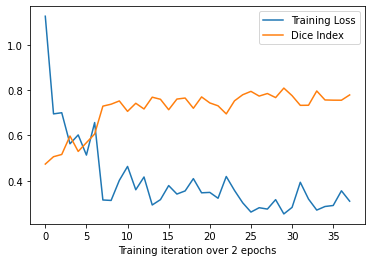

In [0]:
# Plot training logs
plt.plot(tlosses, label = 'Training Loss')
plt.plot(f1s, label = 'Dice Index')
plt.xlabel('Training iteration over 2 epochs')
plt.legend()
plt.show()

In [0]:
# Predict segmentation on invalid masks
test = os.listdir('unet_data/test_images')
masks = {}
for file in test:
  # Read img
  archive = np.load('unet_data/test_images/' + file)
  scan = archive['scan'] 
  mask = archive['mask'] 
  assert np.sum(1. * mask) == 0

  # Preprocess
  maxi = np.max(scan) 
  mini = np.min(scan) 
  scaled_scan = (1. * scan - mini) / (maxi - mini)
  scaled_scan = data_transforms((255. * scaled_scan)).view(-1,1,92,92,92)
  scaled_scan = F.interpolate(scaled_scan, size=128, mode = 'nearest')
  scaled_scan = scaled_scan.float().to(device)

  # Get segmentation
  with torch.no_grad():
    logit = model(scaled_scan)
  seg = torch.max(logit, dim = 1)[1]

  # Reput in the right format
  seg = F.interpolate(seg.view(1,1,128,128,128).to(float), size=92)
  segcpu = seg.to(int).cpu().detach().numpy()[0][0]
  segcpu = segcpu[:,:,::-1]
  masks[file] = segcpu

# Save
with open('missing_masks.pkl', 'wb') as f:
  pickle.dump(masks, f)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [52]:
# Segmentation example playground
color_mappings = {1: (255, 255, 255),   
                  0: (0, 0, 0)}      
archive = np.load('unet_data/train_images/patient_007.npz')
scan = archive['scan'] 
mask = archive['mask'] 

# Preprocess
maxi = np.max(scan) 
mini = np.min(scan) 
scaled_scan = (1. * scan - mini) / (maxi - mini)
scaled_scan = data_transforms((255. * scaled_scan)).view(-1,1,92,92,92)
scaled_scan = F.interpolate(scaled_scan, size=128, mode = 'nearest')
scaled_scan = scaled_scan.float().to(device)

tmask = data_transforms(255. * mask.astype('uint8')).view(-1,1,92,92,92)
tmask = (F.interpolate(tmask, size=128, mode = 'nearest')/255).to(int)

# Get segmentation
with torch.no_grad():
  logit = model(scaled_scan)
seg = torch.max(logit, dim = 1)[1]
seg = F.interpolate(seg.view(1,1,128,128,128).to(float), size=92)
segcpu = seg.to(int).cpu().detach().numpy()[0][0]

tmask = F.interpolate(tmask.view(1,1,128,128,128).to(float), size=92)
ttmask = tmask.cpu().detach().numpy()[0][0]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


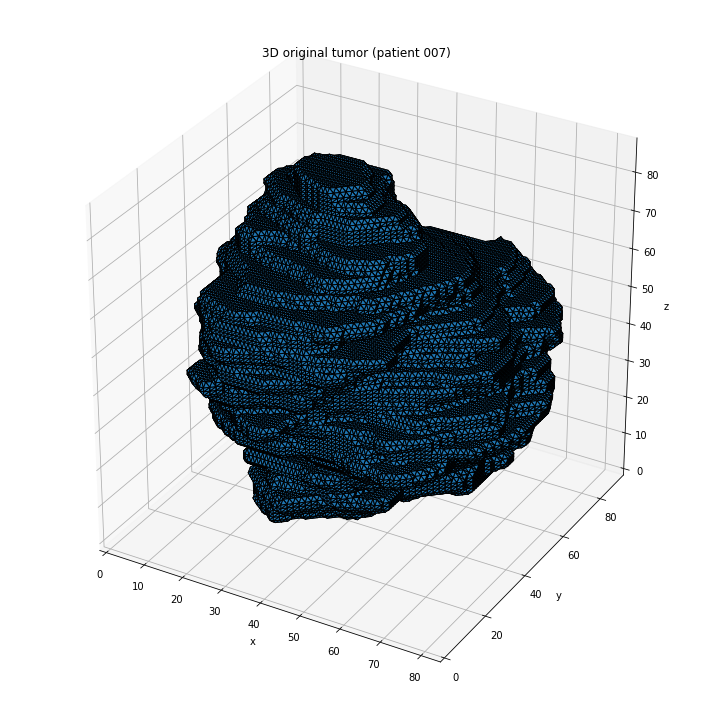

In [56]:
# Tutorial : https://scikit-image.org/docs/dev/auto_examples/edges/plot_marching_cubes.html

# Fancy 3D Tumor Plot

# verts, faces, normals, values = measure.marching_cubes_lewiner(mask.astype('uint8'), 0)
verts, faces, normals, values = measure.marching_cubes_lewiner(ttmask, 0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

x,y,z = zip(*verts)
ax.set_xlim(0, max(x))
ax.set_ylim(0, max(y))
ax.set_zlim(0, max(z))

ax.set_title("3D original tumor (patient 007)")
plt.tight_layout()
plt.show()

In [0]:
masks = pickle.load(open('missing_masks.pkl', 'rb'))

In [0]:
# Plot segmentation
segmentationpred = np.zeros((92,92,92,3))
segmentationpred[segcpu == 0] = color_mappings[0]
segmentationpred[segcpu == 1] = color_mappings[1]
segmentationpred = segmentationpred[:,:,::-1]
skvideo.io.vwrite('Seg.mp4', segmentationpred)
HTML(display_video('Seg.mp4'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


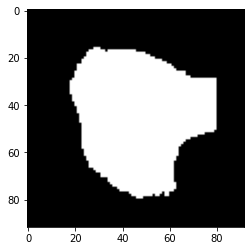

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


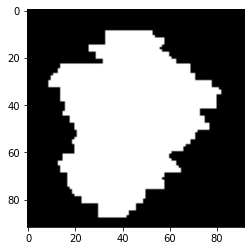

In [0]:
plt.imshow(segmentationpred[:,:,50])
plt.show()
plt.imshow(segmentation[:,:,50])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


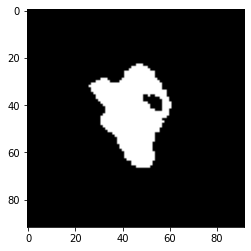

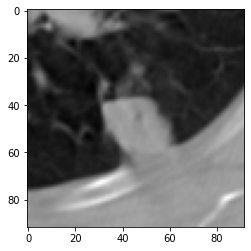

In [0]:
plt.imshow(segmentation[:,:,50])
plt.show()
plt.imshow(scaled_scan[:,:,50], cmap = 'gray')
plt.show()

In [0]:
# Plot original mask (after resize and resize back)
segmentation = np.zeros((92,92,92,3))
segmentation[ttmask == 0] = color_mappings[0]
segmentation[ttmask == 1] = color_mappings[1]
segmentation = segmentation[:,:,::-1]
skvideo.io.vwrite('Seg.mp4', segmentation)
HTML(display_video('Seg.mp4'))

In [0]:
# Plot 3D scan 
scaled_scan, scaled_mask = rescale(scan, mask)
skvideo.io.vwrite('CT_SCAN.mp4', scaled_scan)
HTML(display_video('CT_SCAN.mp4'))

In [0]:
# Plot original mask (before preproc)
skvideo.io.vwrite('MASK.mp4', scaled_mask)
HTML(display_video('MASK.mp4'))

In [0]:
# Feature extraction with U-Net
# path = train_path + 'images'
path = test_path + 'images'
filenames = os.listdir(path)
features = {}

for file in filenames:
    # Read archive
    archive = np.load(path+'/'+file)
    scan = archive['scan'] 

    # Preprocess
    maxi = np.max(scan) 
    mini = np.min(scan) 
    scaled_scan = (1. * scan - mini) / (maxi - mini)
    scaled_scan = data_transforms((255. * scaled_scan)).view(-1,1,92,92,92)
    scaled_scan = F.interpolate(scaled_scan, size=128, mode = 'nearest')
    scaled_scan = scaled_scan.float().to(device)

    # Extract Features
    with torch.no_grad():
      x1 = model.convd1(scaled_scan)
      x2 = model.convd2(x1)
      x3 = model.convd3(x2)
      x4 = model.convd4(x3)
      x5 = model.convd5(x4)
    features[file] = x5[0].cpu().detach().numpy()
    
# with open('seg_train_features.pkl', 'wb') as f:
with open('seg_test_features.pkl', 'wb') as f:
  pickle.dump(features, f)

# Feature Evaluation of Segmentation

In [0]:
train_features = pickle.load(open('seg_train_features.pkl', 'rb'))
test_features = pickle.load(open('seg_test_features.pkl', 'rb'))

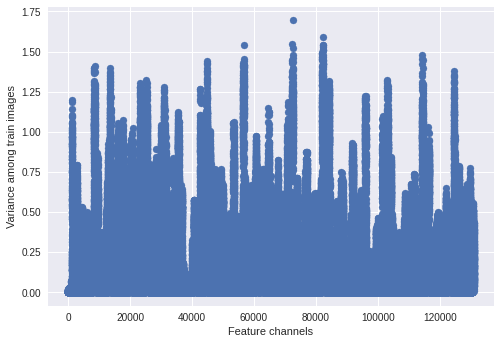

In [89]:
flat = {key.split('.')[0].split('_')[1]:value.flatten() for key, value in train_features.items()}
trainfeatures = pd.DataFrame.from_dict(flat).transpose()
plt.style.use('seaborn')
plt.scatter(x = np.arange(len(trainfeatures.var(axis = 0))), y = trainfeatures.var(axis = 0).values)
plt.xlabel('Feature channels')
plt.ylabel('Variance among train images')
plt.show()

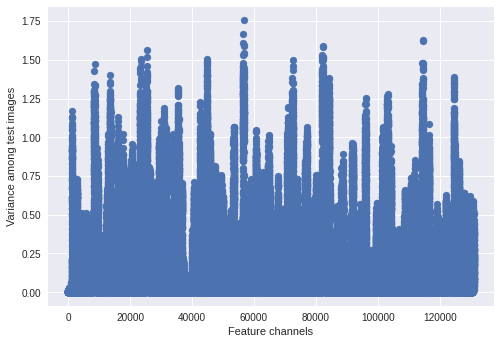

In [71]:
flat = {key.split('.')[0].split('_')[1]:value.flatten() for key, value in test_features.items()}
testfeatures = pd.DataFrame.from_dict(flat).transpose()
plt.style.use('seaborn')
plt.scatter(x = np.arange(len(testfeatures.var(axis = 0))), y = testfeatures.var(axis = 0).values)
plt.xlabel('Feature channels')
plt.ylabel('Variance among test images')
plt.show()

In [0]:
# Get dataframes (+ additional features FOR MIXING ONLY)
train_labels = pd.read_csv('y_train.csv')
trainfeatures = trainfeatures.reset_index(level=0)
trainfeatures['index'] = trainfeatures['index'].astype(int)
traindf = pd.merge(train_labels, trainfeatures, right_on = 'index', left_on = 'PatientID')

In [0]:
trainingdf, valdf = train_test_split(traindf, test_size = 0.2, random_state = 0)
x_train = torch.from_numpy(np.transpose(np.array([trainingdf[i].values for i in range(256*8*8*8)]),(1,0))).type(torch.FloatTensor).to(device)
x_val = torch.from_numpy(np.transpose(np.array([valdf[i].values for i in range(256*8*8*8)]),(1,0))).type(torch.FloatTensor).to(device)
times_train = torch.from_numpy(trainingdf['SurvivalTime'].values).to(device)
times_val = torch.from_numpy(valdf['SurvivalTime'].values).to(device)
events_train = torch.from_numpy(trainingdf['Event'].values).to(device)
events_val = torch.from_numpy(valdf['Event'].values).to(device)
y_train = (times_train, events_train)
y_val = (times_val, events_val)

In [0]:
class Net(nn.Module):
  """Avg Pool 3D 2 + MLP model"""
  def __init__(self, H1 = 2048, H2 = 256, H3 = 64): 
    super(Net, self).__init__()
    self.mlp = nn.Sequential(nn.Linear(16384, H1), 
                             nn.ReLU(), 
                             nn.Dropout(0.5), 
                             nn.Linear(H1, H2),
                             nn.ReLU(), 
                             nn.Dropout(0.5), 
                             nn.Linear(H2, H3), 
                             nn.ReLU(),
                             nn.Dropout(0.3))
    self.fc = nn.Sequential(nn.Linear(H3, 1, bias = False)) # risk computation
  
  def forward(self, x):
    x = x.view(-1,256, 8, 8, 8)
    x = F.avg_pool3d(x, (2, 2, 2))
    x = x.view(-1, 16384)
    x = self.mlp(x)
    x = torch.exp(self.fc(x))
    return x

class MiniNet(nn.Module):
  """AvgPool3D 4 + MLP model"""
  def __init__(self, H1 = 128, H2 = 32): 
    super(MiniNet, self).__init__()
    self.mlp = nn.Sequential(nn.Linear(2048, H1),
                             nn.ReLU(), 
                             nn.Dropout(0.5), 
                             nn.Linear(H1, H2), 
                             nn.ReLU(),
                             nn.Dropout(0.3))
    self.fc = nn.Sequential(nn.Linear(H2, 1, bias = False)) # risk computation
  
  def forward(self, x):
    x = x.view(-1,256, 8, 8, 8)
    x = F.avg_pool3d(x, (4, 4, 4))
    x = x.view(-1, 2048)
    x = self.mlp(x)
    x = torch.exp(self.fc(x))
    return x

In [0]:
# Define model
net = Net()
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
optimizer = tt.optim.SGD(lr=1e-3, momentum=0.9, weight_decay=3e-4, nesterov=True)
model = CoxPH(net, optimizer = optimizer, device = device)

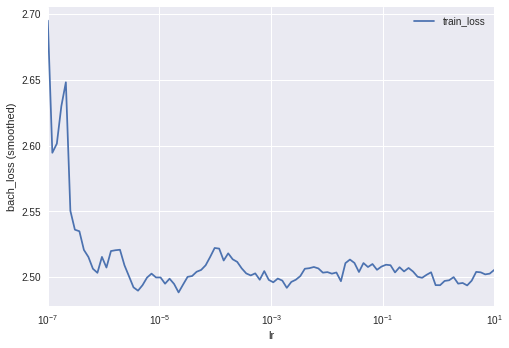

0.0001


In [236]:
# Get best learning rate - OFTEN OVERESTIMATED
batch_size = 20 # TAKE A INT DIVIDING DATA LENGTHS OR DEFINE PROPER TORCH DATALOADERS
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance = 10)
lrfinder.plot()
plt.show()
print(lrfinder.get_best_lr())

100:	[0s / 0s],		train_loss: 2.3477,	val_loss: 2.4650
101:	[0s / 1s],		train_loss: 2.3721,	val_loss: 2.4703
102:	[0s / 1s],		train_loss: 2.3851,	val_loss: 2.4768
103:	[0s / 1s],		train_loss: 2.3742,	val_loss: 2.4739
104:	[0s / 2s],		train_loss: 2.3315,	val_loss: 2.4654
105:	[0s / 2s],		train_loss: 2.3286,	val_loss: 2.4723
106:	[0s / 2s],		train_loss: 2.3344,	val_loss: 2.4746
107:	[0s / 3s],		train_loss: 2.3506,	val_loss: 2.4729
108:	[0s / 3s],		train_loss: 2.3617,	val_loss: 2.4721
109:	[0s / 3s],		train_loss: 2.3364,	val_loss: 2.4773
110:	[0s / 4s],		train_loss: 2.3521,	val_loss: 2.4787


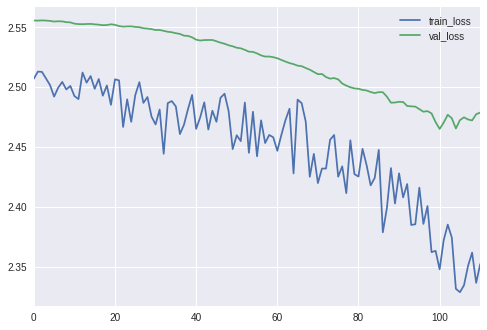

-3.5184950828552246


In [240]:
# Training 
model.optimizer.set_lr(0.0001)
batch_size = 20
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, 
                val_data = (x_val, y_val), val_batch_size = batch_size)
log.plot()
plt.show()
print(model.partial_log_likelihood(*(x_val,y_val)).mean())

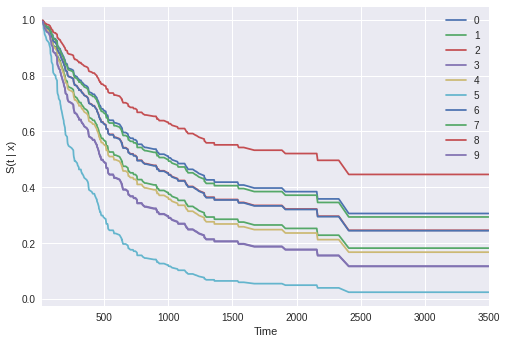

In [238]:
# Validation predictions of survival
_ = model.compute_baseline_hazards()
surv = model.predict_surv_df(x_val)
surv.iloc[:,:10].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

0.644114921223355
0.592771502919237


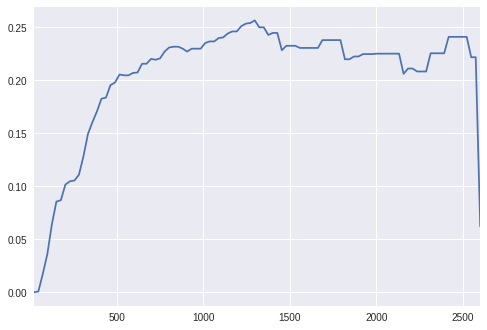

In [239]:
# Evaluation on validation set
dur = times_val.cpu().detach().numpy()
eve = events_val.cpu().detach().numpy()
ev = EvalSurv(surv, dur, eve, censor_surv='km')
print(ev.concordance_td())
time_grid = np.linspace(dur.min(), dur.max(), 100)
_ = ev.brier_score(time_grid).plot()
print(ev.integrated_nbll(time_grid))

Not Good...

# Wavelet

In [23]:
folder_path = 'images-wavelet'
patient_path = os.listdir('images-wavelet')[0]
images_path = os.listdir(folder_path+'/'+patient_path)
wavelets = {}
for path in images_path:
  wavelets[path.split('-')[1].split('_')[0]] = nrrd.read(folder_path+'/'+patient_path+'/'+path)[0]
print(wavelets.keys())

dict_keys(['LLH', 'LHL', 'HHL', 'LHH', 'HHH', 'LLL', 'HLL', 'HLH'])


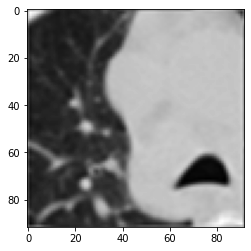

In [26]:
x = 'LLL'
maxi = np.max(wavelets[x]) 
mini = np.min(wavelets[x]) 
scaled_wavelet = 255 * (1. * wavelets[x] - mini) / (maxi - mini)
scaled_wavelet = scaled_wavelet.astype(int)

plt.imshow(scaled_wavelet[30], cmap = 'gray')
plt.show()

# Plot a 3D scan as a video
skvideo.io.vwrite('CT_SCAN.mp4', scaled_wavelet)
HTML(display_video('CT_SCAN.mp4'))

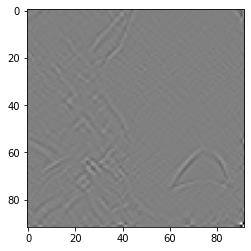

In [27]:
x = 'LHH'
maxi = np.max(wavelets[x]) 
mini = np.min(wavelets[x]) 
scaled_wavelet = 255 * (1. * wavelets[x] - mini) / (maxi - mini)
scaled_wavelet = scaled_wavelet.astype(int)

plt.imshow(scaled_wavelet[30], cmap = 'gray')
plt.show()

# Plot a 3D scan as a video
skvideo.io.vwrite('CT_SCAN.mp4', scaled_wavelet)
HTML(display_video('CT_SCAN.mp4'))

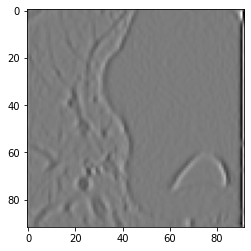

In [28]:
x = 'LLH'
maxi = np.max(wavelets[x]) 
mini = np.min(wavelets[x]) 
scaled_wavelet = 255 * (1. * wavelets[x] - mini) / (maxi - mini)
scaled_wavelet = scaled_wavelet.astype(int)

plt.imshow(scaled_wavelet[30], cmap = 'gray')
plt.show()

# Plot a 3D scan as a video
skvideo.io.vwrite('CT_SCAN.mp4', scaled_wavelet)
HTML(display_video('CT_SCAN.mp4'))

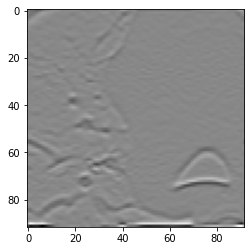

In [29]:
x = 'LHL'
maxi = np.max(wavelets[x]) 
mini = np.min(wavelets[x]) 
scaled_wavelet = 255 * (1. * wavelets[x] - mini) / (maxi - mini)
scaled_wavelet = scaled_wavelet.astype(int)

plt.imshow(scaled_wavelet[30], cmap = 'gray')
plt.show()

# Plot a 3D scan as a video
skvideo.io.vwrite('CT_SCAN.mp4', scaled_wavelet)
HTML(display_video('CT_SCAN.mp4'))

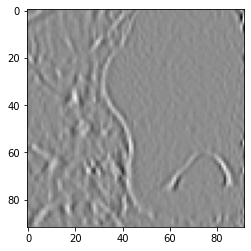

In [30]:
x = 'HLH'
maxi = np.max(wavelets[x]) 
mini = np.min(wavelets[x]) 
scaled_wavelet = 255 * (1. * wavelets[x] - mini) / (maxi - mini)
scaled_wavelet = scaled_wavelet.astype(int)

plt.imshow(scaled_wavelet[30], cmap = 'gray')
plt.show()

# Plot a 3D scan as a video
skvideo.io.vwrite('CT_SCAN.mp4', scaled_wavelet)
HTML(display_video('CT_SCAN.mp4'))

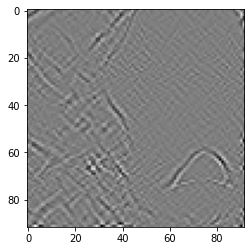

In [31]:
x = 'HHH'
maxi = np.max(wavelets[x]) 
mini = np.min(wavelets[x]) 
scaled_wavelet = 255 * (1. * wavelets[x] - mini) / (maxi - mini)
scaled_wavelet = scaled_wavelet.astype(int)

plt.imshow(scaled_wavelet[30], cmap = 'gray')
plt.show()

# Plot a 3D scan as a video
skvideo.io.vwrite('CT_SCAN.mp4', scaled_wavelet)
HTML(display_video('CT_SCAN.mp4'))

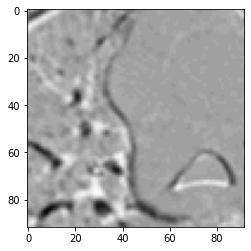

In [32]:
x = 'HLL'
maxi = np.max(wavelets[x]) 
mini = np.min(wavelets[x]) 
scaled_wavelet = 255 * (1. * wavelets[x] - mini) / (maxi - mini)
scaled_wavelet = scaled_wavelet.astype(int)

plt.imshow(scaled_wavelet[30], cmap = 'gray')
plt.show()

# Plot a 3D scan as a video
skvideo.io.vwrite('CT_SCAN.mp4', scaled_wavelet)
HTML(display_video('CT_SCAN.mp4'))

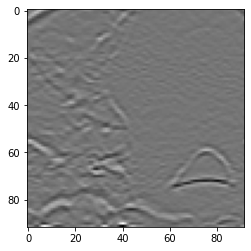

In [33]:
x = 'HHL'
maxi = np.max(wavelets[x]) 
mini = np.min(wavelets[x]) 
scaled_wavelet = 255 * (1. * wavelets[x] - mini) / (maxi - mini)
scaled_wavelet = scaled_wavelet.astype(int)

plt.imshow(scaled_wavelet[30], cmap = 'gray')
plt.show()

# Plot a 3D scan as a video
skvideo.io.vwrite('CT_SCAN.mp4', scaled_wavelet)
HTML(display_video('CT_SCAN.mp4'))

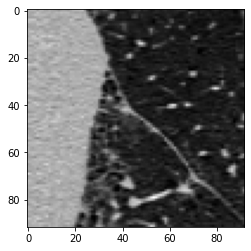

In [36]:
def rescale(scan, mask):
    """Scales scan and mask to 0 - 255 for later plots"""
    maxi = np.max(scan) # 1023 (actually not exactly for all images)
    mini = np.min(scan) # -1024 (actually not exactly for all images)

    scaled_scan = 255 * (1. * scan - mini) / (maxi - mini)
    scaled_scan = scaled_scan.astype(int)

    scaled_mask = mask.astype(int) * 255
    
    return scaled_scan, scaled_mask

def display_video(name):
    """Display video"""
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video width="320" height="240" controls>
              <source src="data:video/mp4;base64,{0}" type="video/mp4" />
              </video>'''.format(encoded.decode('ascii'))

archive = np.load(train_path+'images/patient_222.npz')
scan = archive['scan'] 
mask = archive['mask'] 
scaled_scan, scaled_mask = rescale(scan, mask)

plt.imshow(scaled_scan[30], cmap = 'gray')
plt.show()

# Plot a 3D scan as a video
skvideo.io.vwrite('CT_SCAN.mp4', scaled_scan)
HTML(display_video('CT_SCAN.mp4'))

In [0]:
# Plot a 3D mask as a video
skvideo.io.vwrite('MASK.mp4', scaled_mask)
HTML(display_video('MASK.mp4'))

# LoG

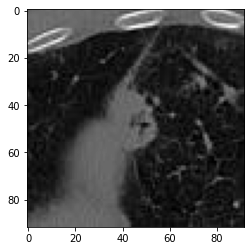

0.1


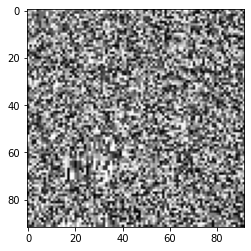

1


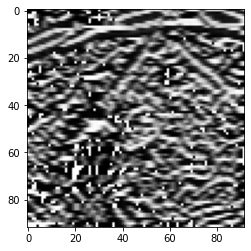

2


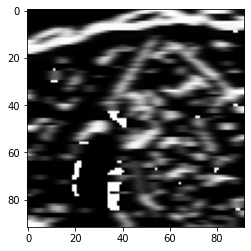

3


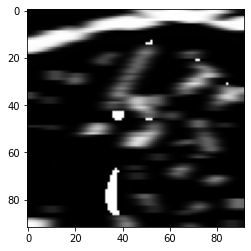

4


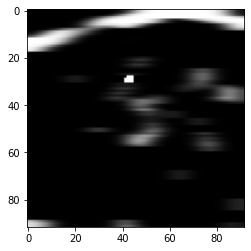

5


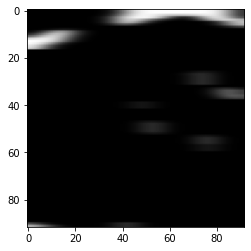

In [35]:
img = plt.imread('best_slices/patient_222.jpg')[:,:,0]
plt.imshow(img, cmap = 'gray')
plt.show()

sigmas = [0.1,1,2,3,4,5]
for sigma in sigmas:
  log = scipy.ndimage.gaussian_laplace(img, sigma = sigma)
  print(sigma)
  plt.imshow(log, cmap = 'gray')
  plt.show()